<a href="https://colab.research.google.com/github/bmybest/NEXTGEN-AI-CAMP/blob/main/%E0%B8%AD%E0%B8%B8%E0%B9%84%E0%B8%A3%E0%B8%AD%E0%B8%A3_CNN_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

โมเดล Convolutional Neural Networks (CNNs) จำแนกอาหาร 4 ประเภท

Classification with PyTorch

นางสาวอุไรอร ปิ่นศิริ email: bestbronze08@gmail.com

In [ ]:
import torch.nn as nn
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,SubsetRandomSampler
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy
import cv2
import os
import matplotlib.pyplot as plt
from glob import glob
from sklearn.model_selection import train_test_split
import shutil
from PIL import ImageFile
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
ImageFile.LOAD_TRUNCATED_IMAGES = True
import csv

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#https://github.com/NextGen-AI-Camp/curriculum/releases/download/CNN2-Exercise-Dataset/train_set.zip
#https://github.com/NextGen-AI-Camp/curriculum/releases/download/CNN2-Exercise-Dataset/test_set.zip
!curl -L -o train_set.zip https://github.com/NextGen-AI-Camp/curriculum/releases/download/CNN2-Exercise-Dataset/train_set.zip
!unzip -o  train_set.zip

!curl -L -o test_set.zip https://github.com/NextGen-AI-Camp/curriculum/releases/download/CNN2-Exercise-Dataset/test_set.zip
!unzip -o  test_set.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  189M  100  189M    0     0  99.4M      0  0:00:01  0:00:01 --:--:--  119M
Archive:  train_set.zip
  inflating: train/BooPadPongali/002.jpg  
  inflating: train/BooPadPongali/003.jpg  
  inflating: train/BooPadPongali/004.jpg  
  inflating: train/BooPadPongali/005.jpg  
  inflating: train/BooPadPongali/006.jpg  
  inflating: train/BooPadPongali/007.jpg  
  inflating: train/BooPadPongali/008.jpg  
  inflating: train/BooPadPongali/011.jpg  
  inflating: train/BooPadPongali/013.jpg  
  inflating: train/BooPadPongali/014.jpg  
  inflating: train/BooPadPongali/015.jpg  
  inflating: train/BooPadPongali/016.jpg  
  inflating: train/BooPadPongali/017.jpg  
  inflating: train/BooPadPongali/018.jpg  
  inflating: train/BooPadPongali/021.jpg  
  inflating: tr

In [ ]:
# Utility
def copy_files_to_new_folders(original_dataset_dir, train_files, test_files, val_files):
    splits = [('train', train_files), ('test', test_files), ('val', val_files)]
    for split_name, files in splits:
        split_dir = os.path.join(original_dataset_dir, split_name)
        for file_path in files:
            class_name = os.path.basename(os.path.dirname(file_path))
            new_file_path = os.path.join(split_dir, class_name, os.path.basename(file_path))
            os.makedirs(os.path.dirname(new_file_path), exist_ok=True)
            shutil.copyfile(file_path, new_file_path)

def get_file_paths(dataset_dir):
    subdirs = [os.path.join(dataset_dir, d) for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]
    file_paths = []
    for subdir in subdirs:
        file_paths.extend(glob(os.path.join(subdir, '*')))
    return file_paths

def split_dataset(file_paths, train_size=0.7, val_size=0.2, seed=42):
    train_files, test_files = train_test_split(file_paths, train_size=train_size, random_state=seed)
    train_files, val_files = train_test_split(train_files, test_size=val_size, random_state=seed)
    return train_files, test_files, val_files

def count_classes(file_list):
    class_counts = {}
    for file_path in file_list:
        class_name = os.path.basename(os.path.dirname(file_path))
        class_counts[class_name] = class_counts.get(class_name, 0) + 1
    return class_counts

def center_crop_image(img, target_size=(64, 64)):
    new_dim = target_size[0] + 3

    if img.shape[1] > img.shape[0]:
        aspect_ratio = img.shape[1] / img.shape[0]
        new_width = int(new_dim * aspect_ratio)
        resized_img = cv2.resize(img, (new_width, new_dim))
    else:
        aspect_ratio = img.shape[1] / img.shape[0]
        new_height = int(new_dim / aspect_ratio)
        resized_img = cv2.resize(img, (new_dim, new_height))

    width, height = resized_img.shape[1], resized_img.shape[0]
    crop_width = min(target_size[0], width)
    crop_height = min(target_size[1], height)
    mid_x, mid_y = width // 2, height // 2
    cw2, ch2 = crop_width // 2, crop_height // 2

    cropped_img = resized_img[mid_y - ch2: mid_y + ch2, mid_x - cw2: mid_x + cw2]

    return cropped_img

def prepare_data(dataset_dir,seed=42):
    file_paths = get_file_paths(dataset_dir)
    train_files, test_files, val_files = split_dataset(file_paths, train_size=0.7, val_size=0.2,seed=seed)
    print("Training files:", len(train_files))
    print("Testing files:", len(test_files))
    print("Validation files:", len(val_files))
    train_counts = count_classes(train_files)
    test_counts = count_classes(test_files)
    val_counts = count_classes(val_files)
    print("Training files per class:", train_counts)
    print("Testing files per class:", test_counts)
    print("Validation files per class:", val_counts)
    return [train_files, test_files, val_files]

def explore(image_paths,center_crop=False):
    dataset_width = []
    dataset_height = []
    dataset_channels = []
    dataset_aspect_ratio = []
    avg_brightness_gray =[]
    avg_brightness_r = []
    avg_brightness_g = []
    avg_brightness_b = []

    for filename in image_paths:
        img = cv2.imread(filename)
        if center_crop:
            img = center_crop_image(img)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            h, w, c = img.shape
            dataset_width.append(w)
            dataset_height.append(h)
            dataset_channels.append(c)
            dataset_aspect_ratio.append(w / h)
            red = np.mean(img[...,0])
            avg_brightness_r.append(red)
            green = np.mean(img[...,1])
            avg_brightness_g.append(green)
            blue = np.mean(img[...,2])
            avg_brightness_b.append(blue)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            avg_brightness_gr = np.mean(gray)
            avg_brightness_gray.append(avg_brightness_gr)
    return dataset_width,dataset_height,dataset_channels,dataset_aspect_ratio,avg_brightness_gray,avg_brightness_r,avg_brightness_g,avg_brightness_b

def compute_max_values(datasets):
    max_width = max_height = max_aspect_ratio = max_brightness_gray = max_brightness_rgb = float('-inf')

    for dataset in datasets:
        dataset_width, dataset_height, _, dataset_aspect_ratio, avg_brightness_gray, avg_brightness_r, avg_brightness_g, avg_brightness_b = explore(dataset)

        max_width = max(max_width, max(dataset_width))
        max_height = max(max_height, max(dataset_height))
        max_aspect_ratio = max(max_aspect_ratio, max(dataset_aspect_ratio))
        max_brightness_gray = max(max_brightness_gray, max(avg_brightness_gray))
        max_brightness_rgb = max(max_brightness_rgb, max(avg_brightness_r), max(avg_brightness_g), max(avg_brightness_b))

    return max_width, max_height, max_aspect_ratio, max_brightness_gray, max_brightness_rgb

def summary(dataset_dir,seed,center_crop=False):
    train_files, test_files, val_files = prepare_data(dataset_dir, seed=seed)
    max_len = 0
    for ele in [train_files, test_files, val_files]:
        max_len = max(max_len, len(ele))
    max_width, max_height, max_aspect_ratio, max_brightness_gray, max_brightness_rgb = compute_max_values([train_files, test_files, val_files])

    row_labels = ['Train', 'Test', 'Val']
    fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(10, 8))
    fig.suptitle(f'Dataset Exploration: Train, Test, and Validation Sets\nSEED: {seed}', fontsize=20, weight='bold')
    font_size = 6
    title_font_size = font_size + 2
    for index, dataset in enumerate([train_files, test_files, val_files]):
        dataset_width, dataset_height, _, dataset_aspect_ratio, avg_brightness_gray, avg_brightness_r, avg_brightness_g, avg_brightness_b = explore(dataset,center_crop=center_crop)

        ax[index, 0].scatter(dataset_width, dataset_height, marker='x',)
        ax[index, 0].plot([0, max_width+200], [0, max_width+200], color='red', label='aspect ratio = 1')
        ax[index, 0].legend(fontsize=font_size)
        ax[index, 0].set_xlim([0, max(max_width,max_height)+50])
        ax[index, 0].set_ylim([0, max(max_width,max_height)+50])
        ax[index, 0].tick_params(axis='both', labelsize=font_size)
        ax[index, 0].set_xlabel('Width', fontsize=font_size)
        ax[index, 0].set_ylabel('Height', fontsize=font_size)
        ax[index, 0].set_title('Scatter Plot of Dataset Width and Height', fontsize=font_size)

        ax[index, 1].hist(dataset_aspect_ratio)
        ax[index, 1].set_ylim([0, max_len+50])
        ax[index, 1].tick_params(axis='both', labelsize=font_size)
        ax[index, 1].set_xlabel('Aspect Ratio', fontsize=font_size)
        ax[index, 1].set_ylabel('Frequency', fontsize=font_size)
        ax[index, 1].set_title('Aspect Ratio Distribution', fontsize=font_size)

        ax[index, 2].boxplot(avg_brightness_gray, vert=False, patch_artist=True, showmeans=True)
        ax[index, 2].set_xlim([0, max_brightness_gray+50])
        ax[index, 2].tick_params(axis='both', labelsize=font_size)
        ax[index, 2].set_xlabel("Average Brightness", fontsize=font_size)
        ax[index, 2].set_title("Box Plot of Average Brightness for Images", fontsize=font_size)

        ax[index, 3].boxplot([avg_brightness_r, avg_brightness_g, avg_brightness_b], vert=False, patch_artist=True, showmeans=True)
        ax[index, 3].set_xlim([0, max_brightness_rgb+50])
        ax[index, 3].tick_params(axis='both', labelsize=font_size)
        ax[index, 3].set_xlabel("Average Brightness", fontsize=font_size)
        ax[index, 3].set_yticklabels(['R', 'G', 'B'], fontsize=font_size)
        ax[index, 3].set_title("Box Plot of Average Brightness for Images", fontsize=font_size)

        ax[index, 0].text(-0.5, 0.5, row_labels[index],  fontsize=font_size, weight='bold', transform=ax[index, 0].transAxes)

    plt.tight_layout()
    plt.show()

Training files: 580
Testing files: 311
Validation files: 145
Training files per class: {'FriedKale': 182, 'MassamanGai': 137, 'PadPakBung': 90, 'BooPadPongali': 171}
Testing files per class: {'PadPakBung': 37, 'FriedKale': 98, 'BooPadPongali': 102, 'MassamanGai': 74}
Validation files per class: {'MassamanGai': 36, 'BooPadPongali': 59, 'FriedKale': 31, 'PadPakBung': 19}


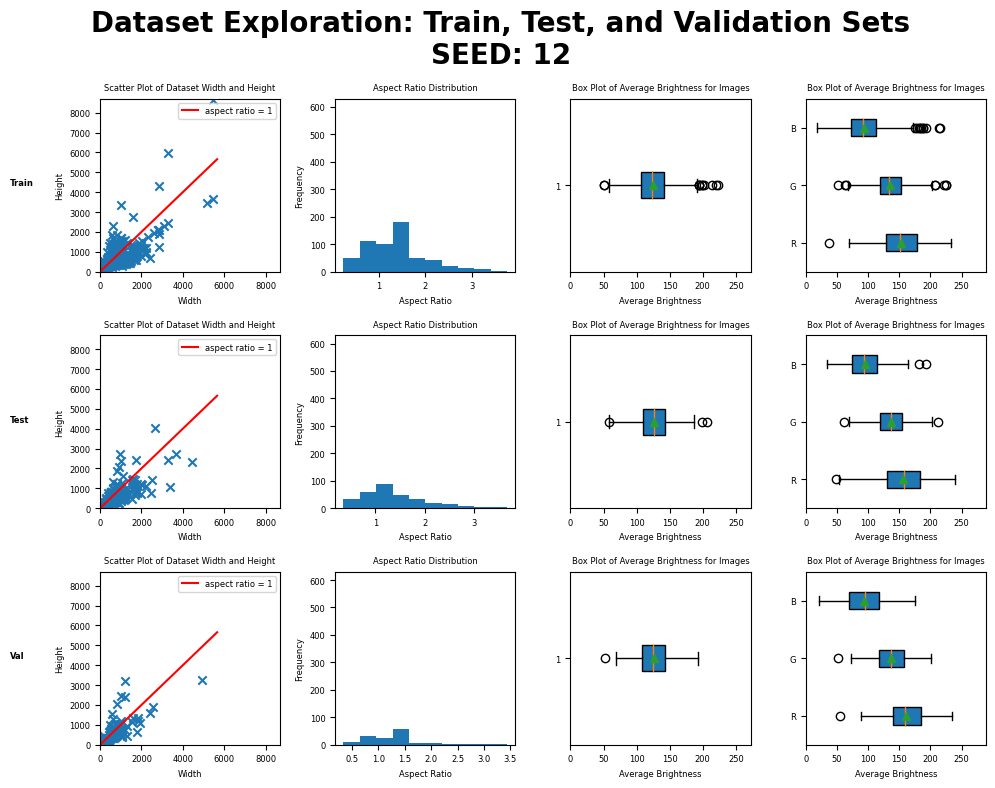

Training files: 580
Testing files: 311
Validation files: 145
Training files per class: {'BooPadPongali': 195, 'MassamanGai': 140, 'FriedKale': 169, 'PadPakBung': 76}
Testing files per class: {'FriedKale': 101, 'PadPakBung': 43, 'BooPadPongali': 83, 'MassamanGai': 84}
Validation files per class: {'FriedKale': 41, 'MassamanGai': 23, 'PadPakBung': 27, 'BooPadPongali': 54}


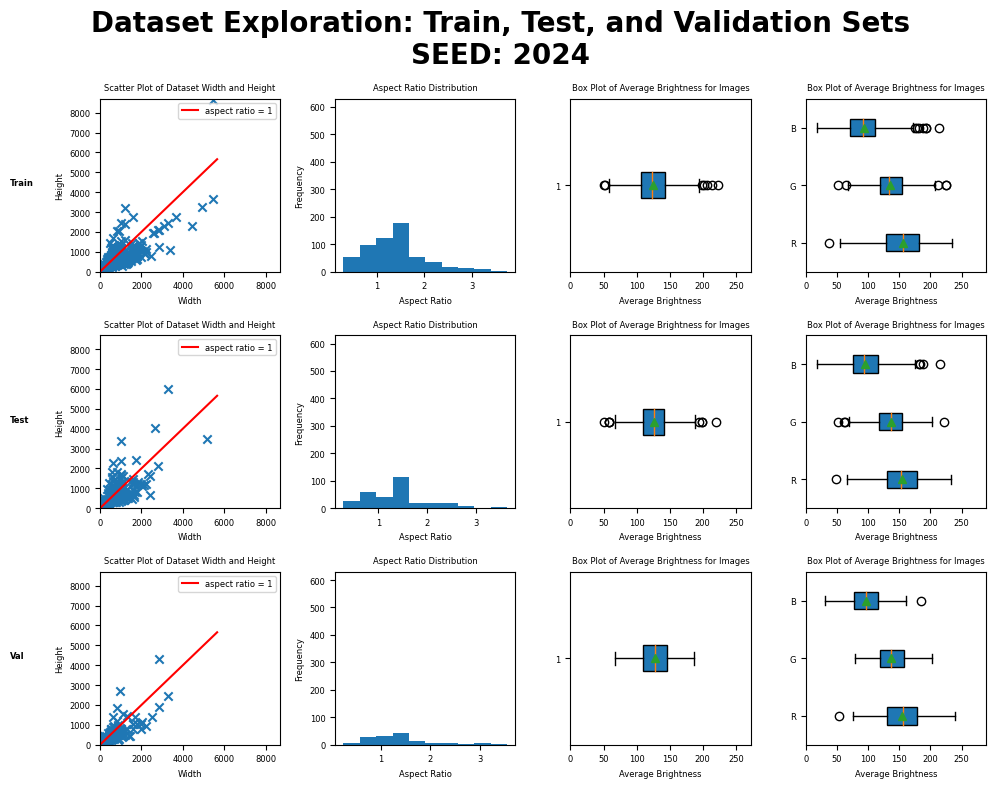

Training files: 580
Testing files: 311
Validation files: 145
Training files per class: {'BooPadPongali': 182, 'MassamanGai': 144, 'FriedKale': 164, 'PadPakBung': 90}
Testing files per class: {'MassamanGai': 68, 'PadPakBung': 37, 'BooPadPongali': 106, 'FriedKale': 100}
Validation files per class: {'MassamanGai': 35, 'BooPadPongali': 44, 'PadPakBung': 19, 'FriedKale': 47}


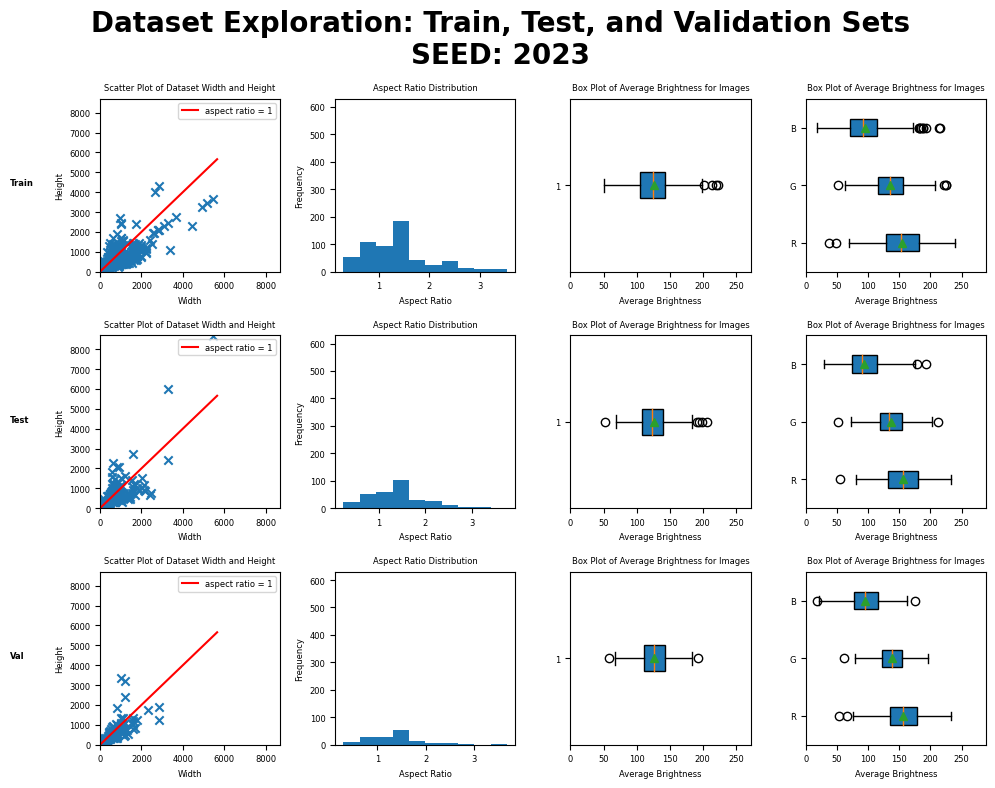

In [ ]:
dataset_dir = "/content/train"
summary(dataset_dir, 12)
summary(dataset_dir, 2024)
summary(dataset_dir, 2023)

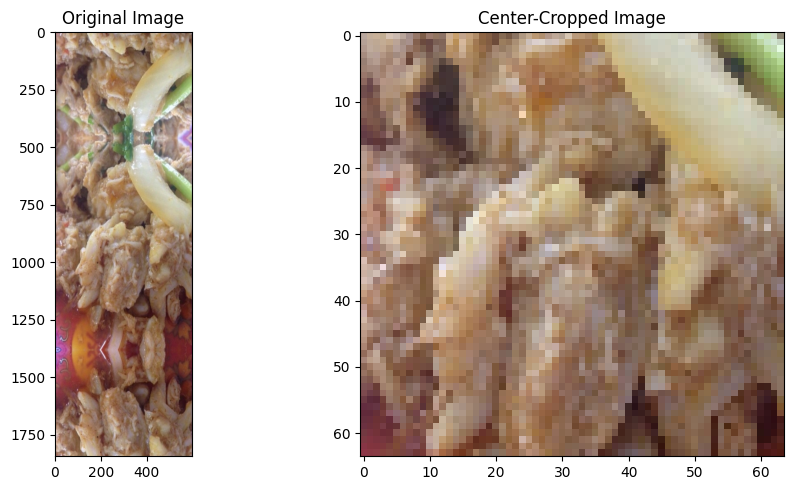

In [ ]:
og_img = cv2.imread('/content/train/BooPadPongali/014.jpg')
og_img = cv2.cvtColor(og_img,cv2.COLOR_BGR2RGB)
img = center_crop_image(og_img,(64,64))
ig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Display the original image
ax[0].imshow(og_img)
ax[0].set_title('Original Image')

# Display the center-cropped image
ax[1].imshow(img)
ax[1].set_title('Center-Cropped Image')


plt.tight_layout()
plt.show()

In [ ]:
seed = 12
dataset_dir = "/content/train"
train_files, test_files, val_files = prepare_data(dataset_dir, seed=seed)

copy_files_to_new_folders(f'/content/seed{seed}', train_files, test_files, val_files)

Training files: 580
Testing files: 311
Validation files: 145
Training files per class: {'FriedKale': 182, 'MassamanGai': 137, 'PadPakBung': 90, 'BooPadPongali': 171}
Testing files per class: {'PadPakBung': 37, 'FriedKale': 98, 'BooPadPongali': 102, 'MassamanGai': 74}
Validation files per class: {'MassamanGai': 36, 'BooPadPongali': 59, 'FriedKale': 31, 'PadPakBung': 19}


In [ ]:
def load_data(path,is_test=False):
    torch.manual_seed(12)

    if is_test:
        transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((64, 64)),
        ])
        dataset = ImageFolder(path, transform=transform)
#translate=(0.05, 0.05) เลื่อนไป, scale=(0.8, 1.2) ย่อขยาย
    else:
        transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((66, 66)),
        transforms.Pad(65, padding_mode='reflect'),
        transforms.RandomAffine(degrees=15, translate=(0.05, 0.05),scale=(0.8, 1.2), shear=10),
        transforms.CenterCrop(64),
        ])
        dataset = ImageFolder(path, transform=transform)
    class_names = dataset.classes
    print("class_names",class_names)
    data_loader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=16, pin_memory=True)

    print("📃Dataset:")
    class_counts_train = [0] * len(class_names)
    for _, target in dataset:
        class_counts_train[target] += 1

    for class_name, class_count in zip(class_names, class_counts_train):
        print(f"\tNumber of images in class {class_name}: {class_count}")

    print(f"\tNumber of samples: {len(dataset)}")

    return dataset

In [ ]:
train_dataset = load_data('/content/seed12/train')
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=16, pin_memory=True)
test_dataset = load_data('/content/seed12/test',is_test=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=16, pin_memory=True)
val_dataset = load_data('/content/seed12/val',is_test=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True, num_workers=16, pin_memory=True)

class_names ['BooPadPongali', 'FriedKale', 'MassamanGai', 'PadPakBung']
📃Dataset:


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


	Number of images in class BooPadPongali: 171
	Number of images in class FriedKale: 182
	Number of images in class MassamanGai: 137
	Number of images in class PadPakBung: 90
	Number of samples: 580
class_names ['BooPadPongali', 'FriedKale', 'MassamanGai', 'PadPakBung']
📃Dataset:
	Number of images in class BooPadPongali: 102
	Number of images in class FriedKale: 98
	Number of images in class MassamanGai: 74
	Number of images in class PadPakBung: 37
	Number of samples: 311
class_names ['BooPadPongali', 'FriedKale', 'MassamanGai', 'PadPakBung']
📃Dataset:
	Number of images in class BooPadPongali: 59
	Number of images in class FriedKale: 31
	Number of images in class MassamanGai: 36
	Number of images in class PadPakBung: 19
	Number of samples: 145


In [ ]:
def imshow_grid(images, labels, class_names):
    num_images = len(images)
    num_rows = int(np.ceil(np.sqrt(num_images)))
    num_cols = int(np.ceil(num_images / num_rows))

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6),dpi=100)
    for i, ax in enumerate(axes.flat):
        if i < num_images:
            image = images[i].permute(1, 2, 0)
            label = labels[i].item()
            ax.imshow(torch.clamp(image,0,1))
            ax.set_title(class_names[label])
            ax.axis('off')
        else:
            ax.axis('off')
    plt.tight_layout()
    plt.show()

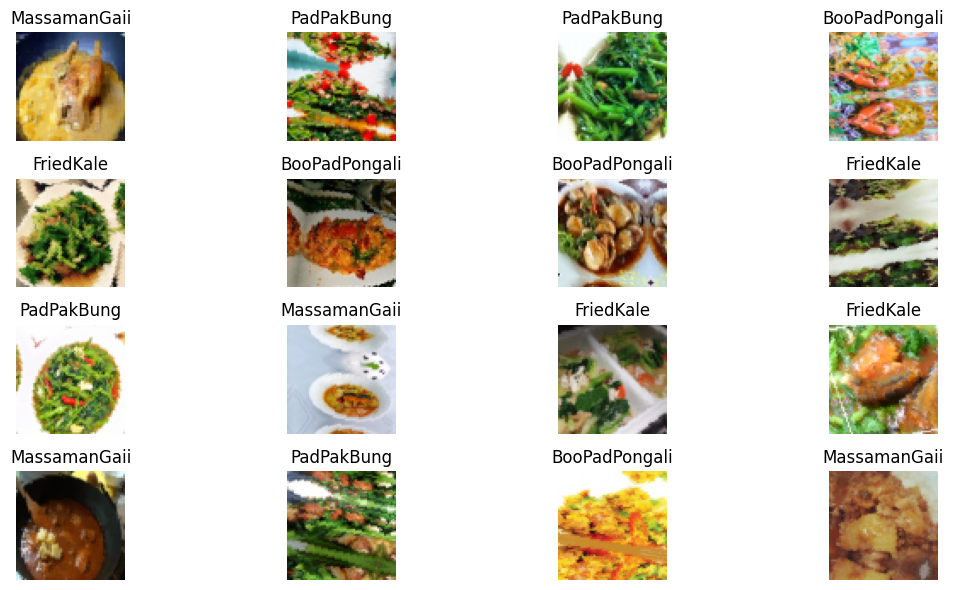

In [ ]:
class_names = ['BooPadPongali', 'FriedKale', 'MassamanGaii', 'PadPakBung']
batch, labels = next(iter(train_loader))
imshow_grid(batch, labels, class_names)

In [ ]:
class CustomLeNet5(nn.Module):
    def __init__(self,input_size=(3,64,64)):
        super(CustomLeNet5, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=input_size[0], out_channels=6, kernel_size=5, stride=1, padding=2)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(self._get_input_size_fc1(input_size), 120)
        self.relu3 = nn.ReLU()

        self.fc2 = nn.Linear(120, 84)
        self.relu4 = nn.ReLU()

        self.fc3 = nn.Linear(84, 40)
        self.relu5 = nn.ReLU()

        self.fc4 = nn.Linear(40, 4)

    def _get_input_size_fc1(self, input_shape):
        with torch.no_grad():
            x = torch.zeros(1, *input_shape)
            x = self.conv1(x)
            x = self.relu1(x)
            x = self.pool1(x)

            x = self.conv2(x)
            x = self.relu2(x)
            x = self.pool2(x)

            x = self.flatten(x)
        return x.size(1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.flatten(x)

        x = self.fc1(x)
        x = self.relu3(x)

        x = self.fc2(x)
        x = self.relu4(x)

        x = self.fc3(x)
        x = self.relu5(x)

        x = self.fc4(x)
        return x

In [ ]:
def train(model, opt, loss_fn, train_loader, test_loader, epochs=10, checkpoint_path=None, device='cpu'):
    print("🤖Training on", device)
    model = model.to(device)

    history = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': []
    }

    for epoch in range(epochs):
        model.train()
        train_bar = tqdm(train_loader, desc=f'🚀Training Epoch [{epoch+1}/{epochs}]', unit='batch')

        total_train_loss = 0
        total_train_correct = 0

        for images, labels in train_bar:
            images = images.to(device)
            labels = labels.to(device)

            opt.zero_grad()
            output = model(images)
            loss = loss_fn(output, labels)
            loss.backward()
            opt.step()

            total_train_loss += loss.item()
            predicted = torch.argmax(nn.functional.softmax(output, dim=1), dim=1)
            total_train_correct += (predicted == labels).sum().item()

            train_bar.set_postfix(loss=loss.item())

        avg_train_loss = total_train_loss / len(train_loader)
        avg_train_acc = total_train_correct / len(train_loader.dataset)

        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(avg_train_acc)

        model.eval()
        test_bar = tqdm(test_loader, desc='📄Testing', unit='batch')

        total_test_loss = 0
        total_test_correct = 0

        with torch.no_grad():
            for images, labels in test_bar:
                images = images.to(device)
                labels = labels.to(device)

                output = model(images)
                loss = loss_fn(output, labels)

                total_test_loss += loss.item()
                predicted = torch.argmax(nn.functional.softmax(output, dim=1), dim=1)
                total_test_correct += (predicted == labels).sum().item()

                test_bar.set_postfix(loss=loss.item())

        avg_test_loss = total_test_loss / len(test_loader)
        avg_test_acc = total_test_correct / len(test_loader.dataset)

        history['test_loss'].append(avg_test_loss)
        history['test_acc'].append(avg_test_acc)

        print(f"Summary :")
        print(f"\tTrain \tavg_loss: {avg_train_loss:.4f} \t| avg_acc: {avg_train_acc:.4f}")
        print(f"\tTest \tavg_loss: {avg_test_loss:.4f} \t| avg_acc: {avg_test_acc:.4f}")
        print()

        if checkpoint_path:
            torch.save(model.state_dict(), f"{checkpoint_path}_epoch_{epoch+1}.pth")

    return history

🤖 Training on cpu
🤖Training on cpu


📄Testing: 100%|██████████| 20/20 [00:07<00:00,  2.78batch/s, loss=1.08]


Summary :
	Train 	avg_loss: 1.3320 	| avg_acc: 0.3397
	Test 	avg_loss: 1.0884 	| avg_acc: 0.5434



📄Testing: 100%|██████████| 20/20 [00:07<00:00,  2.60batch/s, loss=0.787]


Summary :
	Train 	avg_loss: 0.9988 	| avg_acc: 0.5086
	Test 	avg_loss: 0.8461 	| avg_acc: 0.5370



📄Testing: 100%|██████████| 20/20 [00:08<00:00,  2.25batch/s, loss=0.972]


Summary :
	Train 	avg_loss: 0.9466 	| avg_acc: 0.5190
	Test 	avg_loss: 0.9650 	| avg_acc: 0.4469



📄Testing: 100%|██████████| 20/20 [00:07<00:00,  2.73batch/s, loss=0.592]


Summary :
	Train 	avg_loss: 0.9271 	| avg_acc: 0.5138
	Test 	avg_loss: 0.8219 	| avg_acc: 0.5691



📄Testing: 100%|██████████| 20/20 [00:06<00:00,  3.06batch/s, loss=0.76]


Summary :
	Train 	avg_loss: 0.9097 	| avg_acc: 0.5069
	Test 	avg_loss: 0.7960 	| avg_acc: 0.5788



📄Testing: 100%|██████████| 20/20 [00:06<00:00,  3.05batch/s, loss=0.796]


Summary :
	Train 	avg_loss: 0.8518 	| avg_acc: 0.5259
	Test 	avg_loss: 0.7855 	| avg_acc: 0.5916



📄Testing: 100%|██████████| 20/20 [00:06<00:00,  2.90batch/s, loss=1.02]


Summary :
	Train 	avg_loss: 0.8872 	| avg_acc: 0.5466
	Test 	avg_loss: 1.0085 	| avg_acc: 0.4309



📄Testing: 100%|██████████| 20/20 [00:06<00:00,  3.14batch/s, loss=0.606]


Summary :
	Train 	avg_loss: 0.8710 	| avg_acc: 0.5500
	Test 	avg_loss: 0.8716 	| avg_acc: 0.5209



📄Testing: 100%|██████████| 20/20 [00:06<00:00,  2.86batch/s, loss=0.867]


Summary :
	Train 	avg_loss: 0.8572 	| avg_acc: 0.5517
	Test 	avg_loss: 0.8378 	| avg_acc: 0.5949



📄Testing: 100%|██████████| 20/20 [00:06<00:00,  3.01batch/s, loss=0.806]


Summary :
	Train 	avg_loss: 0.7992 	| avg_acc: 0.5724
	Test 	avg_loss: 0.8840 	| avg_acc: 0.5273



📄Testing: 100%|██████████| 20/20 [00:07<00:00,  2.63batch/s, loss=0.647]


Summary :
	Train 	avg_loss: 0.8657 	| avg_acc: 0.5397
	Test 	avg_loss: 0.8344 	| avg_acc: 0.5691



📄Testing: 100%|██████████| 20/20 [00:08<00:00,  2.48batch/s, loss=1.86]


Summary :
	Train 	avg_loss: 0.8545 	| avg_acc: 0.5086
	Test 	avg_loss: 0.8569 	| avg_acc: 0.5531



📄Testing: 100%|██████████| 20/20 [00:08<00:00,  2.27batch/s, loss=1.02]


Summary :
	Train 	avg_loss: 0.8101 	| avg_acc: 0.5655
	Test 	avg_loss: 0.7600 	| avg_acc: 0.6077



📄Testing: 100%|██████████| 20/20 [00:07<00:00,  2.76batch/s, loss=0.542]


Summary :
	Train 	avg_loss: 0.7875 	| avg_acc: 0.5914
	Test 	avg_loss: 0.7508 	| avg_acc: 0.6077



📄Testing: 100%|██████████| 20/20 [00:06<00:00,  2.95batch/s, loss=1.46]


Summary :
	Train 	avg_loss: 0.8066 	| avg_acc: 0.5552
	Test 	avg_loss: 0.8157 	| avg_acc: 0.5563



📄Testing: 100%|██████████| 20/20 [00:06<00:00,  3.06batch/s, loss=0.72]


Summary :
	Train 	avg_loss: 0.7773 	| avg_acc: 0.5810
	Test 	avg_loss: 0.7800 	| avg_acc: 0.5788



📄Testing: 100%|██████████| 20/20 [00:06<00:00,  2.96batch/s, loss=0.616]


Summary :
	Train 	avg_loss: 0.7970 	| avg_acc: 0.5741
	Test 	avg_loss: 0.7622 	| avg_acc: 0.5820



📄Testing: 100%|██████████| 20/20 [00:07<00:00,  2.59batch/s, loss=0.641]


Summary :
	Train 	avg_loss: 0.8239 	| avg_acc: 0.5569
	Test 	avg_loss: 0.7923 	| avg_acc: 0.5627



📄Testing: 100%|██████████| 20/20 [00:08<00:00,  2.24batch/s, loss=0.571]


Summary :
	Train 	avg_loss: 0.8159 	| avg_acc: 0.5586
	Test 	avg_loss: 0.7831 	| avg_acc: 0.5820



📄Testing: 100%|██████████| 20/20 [00:09<00:00,  2.06batch/s, loss=0.799]


Summary :
	Train 	avg_loss: 0.8141 	| avg_acc: 0.5948
	Test 	avg_loss: 0.7579 	| avg_acc: 0.5723



📄Testing: 100%|██████████| 20/20 [00:06<00:00,  2.99batch/s, loss=1.44]


Summary :
	Train 	avg_loss: 0.8279 	| avg_acc: 0.5724
	Test 	avg_loss: 0.9245 	| avg_acc: 0.5498



📄Testing: 100%|██████████| 20/20 [00:11<00:00,  1.81batch/s, loss=1.02]


Summary :
	Train 	avg_loss: 0.8114 	| avg_acc: 0.5741
	Test 	avg_loss: 0.8043 	| avg_acc: 0.5370



📄Testing: 100%|██████████| 20/20 [00:07<00:00,  2.79batch/s, loss=0.916]


Summary :
	Train 	avg_loss: 0.7641 	| avg_acc: 0.6000
	Test 	avg_loss: 0.8432 	| avg_acc: 0.5466



📄Testing: 100%|██████████| 20/20 [00:08<00:00,  2.32batch/s, loss=0.659]


Summary :
	Train 	avg_loss: 0.7987 	| avg_acc: 0.5845
	Test 	avg_loss: 0.7461 	| avg_acc: 0.5981



📄Testing: 100%|██████████| 20/20 [00:10<00:00,  1.93batch/s, loss=0.691]


Summary :
	Train 	avg_loss: 0.7677 	| avg_acc: 0.6172
	Test 	avg_loss: 0.7452 	| avg_acc: 0.6463



📄Testing: 100%|██████████| 20/20 [00:06<00:00,  2.95batch/s, loss=0.622]


Summary :
	Train 	avg_loss: 0.7449 	| avg_acc: 0.6207
	Test 	avg_loss: 0.7305 	| avg_acc: 0.6431



📄Testing: 100%|██████████| 20/20 [00:07<00:00,  2.55batch/s, loss=0.744]


Summary :
	Train 	avg_loss: 0.7723 	| avg_acc: 0.5862
	Test 	avg_loss: 0.7509 	| avg_acc: 0.6141



📄Testing: 100%|██████████| 20/20 [00:07<00:00,  2.79batch/s, loss=0.614]


Summary :
	Train 	avg_loss: 0.7638 	| avg_acc: 0.5966
	Test 	avg_loss: 0.7231 	| avg_acc: 0.5981



📄Testing: 100%|██████████| 20/20 [00:07<00:00,  2.58batch/s, loss=0.75]


Summary :
	Train 	avg_loss: 0.7472 	| avg_acc: 0.6379
	Test 	avg_loss: 0.7222 	| avg_acc: 0.6013



📄Testing: 100%|██████████| 20/20 [00:08<00:00,  2.32batch/s, loss=0.776]


Summary :
	Train 	avg_loss: 0.7474 	| avg_acc: 0.6190
	Test 	avg_loss: 0.7228 	| avg_acc: 0.6077



📄Testing: 100%|██████████| 20/20 [00:11<00:00,  1.81batch/s, loss=0.921]


Summary :
	Train 	avg_loss: 0.7568 	| avg_acc: 0.6190
	Test 	avg_loss: 0.7506 	| avg_acc: 0.5949



📄Testing: 100%|██████████| 20/20 [00:06<00:00,  2.88batch/s, loss=0.613]


Summary :
	Train 	avg_loss: 0.7554 	| avg_acc: 0.6259
	Test 	avg_loss: 0.7650 	| avg_acc: 0.5916



📄Testing: 100%|██████████| 20/20 [00:06<00:00,  3.14batch/s, loss=0.675]


Summary :
	Train 	avg_loss: 0.7404 	| avg_acc: 0.6414
	Test 	avg_loss: 0.7388 	| avg_acc: 0.6206



📄Testing: 100%|██████████| 20/20 [00:06<00:00,  2.95batch/s, loss=0.794]


Summary :
	Train 	avg_loss: 0.7403 	| avg_acc: 0.6414
	Test 	avg_loss: 0.6807 	| avg_acc: 0.6270



📄Testing: 100%|██████████| 20/20 [00:08<00:00,  2.31batch/s, loss=0.856]


Summary :
	Train 	avg_loss: 0.7530 	| avg_acc: 0.6276
	Test 	avg_loss: 0.8301 	| avg_acc: 0.5016



📄Testing: 100%|██████████| 20/20 [00:09<00:00,  2.11batch/s, loss=0.612]


Summary :
	Train 	avg_loss: 0.7153 	| avg_acc: 0.6621
	Test 	avg_loss: 0.6923 	| avg_acc: 0.6624



📄Testing: 100%|██████████| 20/20 [00:07<00:00,  2.80batch/s, loss=0.591]


Summary :
	Train 	avg_loss: 0.7151 	| avg_acc: 0.6552
	Test 	avg_loss: 0.7021 	| avg_acc: 0.6045



📄Testing: 100%|██████████| 20/20 [00:06<00:00,  2.89batch/s, loss=0.454]


Summary :
	Train 	avg_loss: 0.7577 	| avg_acc: 0.6155
	Test 	avg_loss: 0.6831 	| avg_acc: 0.6077



📄Testing: 100%|██████████| 20/20 [00:06<00:00,  2.97batch/s, loss=0.741]


Summary :
	Train 	avg_loss: 0.7132 	| avg_acc: 0.6466
	Test 	avg_loss: 0.6651 	| avg_acc: 0.6817



📄Testing: 100%|██████████| 20/20 [00:18<00:00,  1.08batch/s, loss=0.865]


Summary :
	Train 	avg_loss: 0.7282 	| avg_acc: 0.6655
	Test 	avg_loss: 0.7321 	| avg_acc: 0.5949



📄Testing: 100%|██████████| 20/20 [00:08<00:00,  2.26batch/s, loss=0.832]


Summary :
	Train 	avg_loss: 0.7160 	| avg_acc: 0.6466
	Test 	avg_loss: 0.6542 	| avg_acc: 0.6945



📄Testing: 100%|██████████| 20/20 [00:08<00:00,  2.34batch/s, loss=0.512]


Summary :
	Train 	avg_loss: 0.6670 	| avg_acc: 0.6931
	Test 	avg_loss: 0.6991 	| avg_acc: 0.6334



📄Testing: 100%|██████████| 20/20 [00:07<00:00,  2.52batch/s, loss=0.826]


Summary :
	Train 	avg_loss: 0.6617 	| avg_acc: 0.6914
	Test 	avg_loss: 0.6422 	| avg_acc: 0.7074



📄Testing: 100%|██████████| 20/20 [00:08<00:00,  2.45batch/s, loss=0.507]


Summary :
	Train 	avg_loss: 0.6437 	| avg_acc: 0.7138
	Test 	avg_loss: 0.6899 	| avg_acc: 0.6688



📄Testing: 100%|██████████| 20/20 [00:08<00:00,  2.48batch/s, loss=0.76]


Summary :
	Train 	avg_loss: 0.7026 	| avg_acc: 0.6862
	Test 	avg_loss: 0.7462 	| avg_acc: 0.6141



📄Testing: 100%|██████████| 20/20 [00:08<00:00,  2.34batch/s, loss=0.87]


Summary :
	Train 	avg_loss: 0.6541 	| avg_acc: 0.6983
	Test 	avg_loss: 0.6840 	| avg_acc: 0.6367



📄Testing: 100%|██████████| 20/20 [00:08<00:00,  2.43batch/s, loss=0.739]


Summary :
	Train 	avg_loss: 0.6855 	| avg_acc: 0.6931
	Test 	avg_loss: 0.6874 	| avg_acc: 0.6849



📄Testing: 100%|██████████| 20/20 [00:07<00:00,  2.57batch/s, loss=0.784]


Summary :
	Train 	avg_loss: 0.6682 	| avg_acc: 0.6810
	Test 	avg_loss: 0.7354 	| avg_acc: 0.6495



📄Testing: 100%|██████████| 20/20 [00:06<00:00,  3.22batch/s, loss=0.948]


Summary :
	Train 	avg_loss: 0.6473 	| avg_acc: 0.7103
	Test 	avg_loss: 0.6539 	| avg_acc: 0.6720



📄Testing: 100%|██████████| 20/20 [00:07<00:00,  2.69batch/s, loss=0.376]


Summary :
	Train 	avg_loss: 0.6636 	| avg_acc: 0.6897
	Test 	avg_loss: 0.5952 	| avg_acc: 0.7170



📄Testing: 100%|██████████| 20/20 [00:08<00:00,  2.43batch/s, loss=0.859]


Summary :
	Train 	avg_loss: 0.6210 	| avg_acc: 0.7276
	Test 	avg_loss: 0.6510 	| avg_acc: 0.7010



📄Testing: 100%|██████████| 20/20 [00:09<00:00,  2.16batch/s, loss=0.779]


Summary :
	Train 	avg_loss: 0.6417 	| avg_acc: 0.6983
	Test 	avg_loss: 0.6704 	| avg_acc: 0.6656



📄Testing: 100%|██████████| 20/20 [00:06<00:00,  2.93batch/s, loss=0.505]


Summary :
	Train 	avg_loss: 0.6009 	| avg_acc: 0.7431
	Test 	avg_loss: 0.6115 	| avg_acc: 0.7203



📄Testing: 100%|██████████| 20/20 [00:07<00:00,  2.78batch/s, loss=0.514]


Summary :
	Train 	avg_loss: 0.6188 	| avg_acc: 0.7328
	Test 	avg_loss: 0.6500 	| avg_acc: 0.6913



📄Testing: 100%|██████████| 20/20 [00:07<00:00,  2.77batch/s, loss=0.603]


Summary :
	Train 	avg_loss: 0.5968 	| avg_acc: 0.7224
	Test 	avg_loss: 0.6815 	| avg_acc: 0.6431



📄Testing: 100%|██████████| 20/20 [00:10<00:00,  1.89batch/s, loss=0.341]


Summary :
	Train 	avg_loss: 0.6200 	| avg_acc: 0.7086
	Test 	avg_loss: 0.6687 	| avg_acc: 0.6463



📄Testing: 100%|██████████| 20/20 [00:09<00:00,  2.13batch/s, loss=0.79]


Summary :
	Train 	avg_loss: 0.5456 	| avg_acc: 0.7621
	Test 	avg_loss: 0.6236 	| avg_acc: 0.6945



📄Testing: 100%|██████████| 20/20 [00:08<00:00,  2.24batch/s, loss=0.756]


Summary :
	Train 	avg_loss: 0.6313 	| avg_acc: 0.7155
	Test 	avg_loss: 0.6220 	| avg_acc: 0.7170



📄Testing: 100%|██████████| 20/20 [00:10<00:00,  1.88batch/s, loss=0.402]


Summary :
	Train 	avg_loss: 0.5823 	| avg_acc: 0.7500
	Test 	avg_loss: 0.6082 	| avg_acc: 0.6977



📄Testing: 100%|██████████| 20/20 [00:07<00:00,  2.71batch/s, loss=0.772]


Summary :
	Train 	avg_loss: 0.5134 	| avg_acc: 0.7707
	Test 	avg_loss: 0.6803 	| avg_acc: 0.6817



📄Testing: 100%|██████████| 20/20 [00:07<00:00,  2.66batch/s, loss=0.411]


Summary :
	Train 	avg_loss: 0.5703 	| avg_acc: 0.7517
	Test 	avg_loss: 0.5879 	| avg_acc: 0.7267



📄Testing: 100%|██████████| 20/20 [00:07<00:00,  2.70batch/s, loss=0.414]


Summary :
	Train 	avg_loss: 0.5786 	| avg_acc: 0.7586
	Test 	avg_loss: 0.6415 	| avg_acc: 0.6913



📄Testing: 100%|██████████| 20/20 [00:10<00:00,  1.90batch/s, loss=0.502]


Summary :
	Train 	avg_loss: 0.5530 	| avg_acc: 0.7621
	Test 	avg_loss: 0.5568 	| avg_acc: 0.7524



📄Testing: 100%|██████████| 20/20 [00:07<00:00,  2.79batch/s, loss=0.19]


Summary :
	Train 	avg_loss: 0.5307 	| avg_acc: 0.7586
	Test 	avg_loss: 0.7479 	| avg_acc: 0.6881



📄Testing: 100%|██████████| 20/20 [00:07<00:00,  2.75batch/s, loss=0.869]


Summary :
	Train 	avg_loss: 0.5948 	| avg_acc: 0.7431
	Test 	avg_loss: 0.5888 	| avg_acc: 0.7106



📄Testing: 100%|██████████| 20/20 [00:06<00:00,  2.93batch/s, loss=0.409]


Summary :
	Train 	avg_loss: 0.5794 	| avg_acc: 0.7328
	Test 	avg_loss: 0.6686 	| avg_acc: 0.7074



📄Testing: 100%|██████████| 20/20 [00:06<00:00,  3.12batch/s, loss=0.686]


Summary :
	Train 	avg_loss: 0.5382 	| avg_acc: 0.7638
	Test 	avg_loss: 0.6302 	| avg_acc: 0.6913



📄Testing: 100%|██████████| 20/20 [00:06<00:00,  3.07batch/s, loss=0.734]


Summary :
	Train 	avg_loss: 0.5477 	| avg_acc: 0.7500
	Test 	avg_loss: 0.6151 	| avg_acc: 0.7203



📄Testing: 100%|██████████| 20/20 [00:07<00:00,  2.70batch/s, loss=0.634]


Summary :
	Train 	avg_loss: 0.5601 	| avg_acc: 0.7655
	Test 	avg_loss: 0.6183 	| avg_acc: 0.7074



📄Testing: 100%|██████████| 20/20 [00:07<00:00,  2.51batch/s, loss=0.561]


Summary :
	Train 	avg_loss: 0.5170 	| avg_acc: 0.7690
	Test 	avg_loss: 0.6702 	| avg_acc: 0.6785



📄Testing: 100%|██████████| 20/20 [00:08<00:00,  2.34batch/s, loss=0.351]


Summary :
	Train 	avg_loss: 0.5065 	| avg_acc: 0.7897
	Test 	avg_loss: 0.5812 	| avg_acc: 0.7235



📄Testing: 100%|██████████| 20/20 [00:11<00:00,  1.71batch/s, loss=1.84]


Summary :
	Train 	avg_loss: 0.5334 	| avg_acc: 0.7776
	Test 	avg_loss: 0.7040 	| avg_acc: 0.6849



📄Testing: 100%|██████████| 20/20 [00:07<00:00,  2.77batch/s, loss=0.196]


Summary :
	Train 	avg_loss: 0.4943 	| avg_acc: 0.7914
	Test 	avg_loss: 0.5510 	| avg_acc: 0.7428



📄Testing: 100%|██████████| 20/20 [00:07<00:00,  2.67batch/s, loss=0.348]


Summary :
	Train 	avg_loss: 0.5229 	| avg_acc: 0.7707
	Test 	avg_loss: 0.5562 	| avg_acc: 0.7621



📄Testing: 100%|██████████| 20/20 [00:08<00:00,  2.23batch/s, loss=1.09]


Summary :
	Train 	avg_loss: 0.5006 	| avg_acc: 0.7724
	Test 	avg_loss: 0.6159 	| avg_acc: 0.7235



📄Testing: 100%|██████████| 20/20 [00:10<00:00,  1.96batch/s, loss=0.876]


Summary :
	Train 	avg_loss: 0.5292 	| avg_acc: 0.7759
	Test 	avg_loss: 0.6582 	| avg_acc: 0.7042



📄Testing: 100%|██████████| 20/20 [00:07<00:00,  2.65batch/s, loss=1.28]


Summary :
	Train 	avg_loss: 0.5410 	| avg_acc: 0.7741
	Test 	avg_loss: 0.7514 	| avg_acc: 0.6849



📄Testing: 100%|██████████| 20/20 [00:07<00:00,  2.77batch/s, loss=0.631]


Summary :
	Train 	avg_loss: 0.5924 	| avg_acc: 0.7483
	Test 	avg_loss: 0.6711 	| avg_acc: 0.6720



📄Testing: 100%|██████████| 20/20 [00:08<00:00,  2.44batch/s, loss=0.548]


Summary :
	Train 	avg_loss: 0.4958 	| avg_acc: 0.7948
	Test 	avg_loss: 0.5621 	| avg_acc: 0.7556



📄Testing: 100%|██████████| 20/20 [00:12<00:00,  1.63batch/s, loss=0.776]


Summary :
	Train 	avg_loss: 0.4648 	| avg_acc: 0.7983
	Test 	avg_loss: 0.6848 	| avg_acc: 0.7010



📄Testing: 100%|██████████| 20/20 [00:06<00:00,  2.89batch/s, loss=0.515]


Summary :
	Train 	avg_loss: 0.5106 	| avg_acc: 0.7724
	Test 	avg_loss: 0.5654 	| avg_acc: 0.7524



📄Testing: 100%|██████████| 20/20 [00:07<00:00,  2.78batch/s, loss=1.53]


Summary :
	Train 	avg_loss: 0.5421 	| avg_acc: 0.7707
	Test 	avg_loss: 0.6671 	| avg_acc: 0.7235



📄Testing: 100%|██████████| 20/20 [00:07<00:00,  2.69batch/s, loss=0.611]


Summary :
	Train 	avg_loss: 0.4984 	| avg_acc: 0.7845
	Test 	avg_loss: 0.6584 	| avg_acc: 0.7170



📄Testing: 100%|██████████| 20/20 [00:08<00:00,  2.39batch/s, loss=0.586]


Summary :
	Train 	avg_loss: 0.4331 	| avg_acc: 0.8224
	Test 	avg_loss: 0.6317 	| avg_acc: 0.7042



📄Testing: 100%|██████████| 20/20 [00:08<00:00,  2.40batch/s, loss=0.516]


Summary :
	Train 	avg_loss: 0.5138 	| avg_acc: 0.7931
	Test 	avg_loss: 0.6042 	| avg_acc: 0.7363



📄Testing: 100%|██████████| 20/20 [00:09<00:00,  2.15batch/s, loss=0.78]


Summary :
	Train 	avg_loss: 0.4993 	| avg_acc: 0.7879
	Test 	avg_loss: 0.5785 	| avg_acc: 0.7299



📄Testing: 100%|██████████| 20/20 [00:07<00:00,  2.73batch/s, loss=0.943]


Summary :
	Train 	avg_loss: 0.4727 	| avg_acc: 0.7897
	Test 	avg_loss: 0.6436 	| avg_acc: 0.7299



📄Testing: 100%|██████████| 20/20 [00:06<00:00,  2.90batch/s, loss=0.854]


Summary :
	Train 	avg_loss: 0.4615 	| avg_acc: 0.8121
	Test 	avg_loss: 0.6489 	| avg_acc: 0.7235



📄Testing: 100%|██████████| 20/20 [00:07<00:00,  2.85batch/s, loss=1.07]


Summary :
	Train 	avg_loss: 0.4623 	| avg_acc: 0.7862
	Test 	avg_loss: 0.6196 	| avg_acc: 0.7395



📄Testing: 100%|██████████| 20/20 [00:07<00:00,  2.75batch/s, loss=0.179]


Summary :
	Train 	avg_loss: 0.4466 	| avg_acc: 0.8138
	Test 	avg_loss: 0.6084 	| avg_acc: 0.7428



📄Testing: 100%|██████████| 20/20 [00:08<00:00,  2.43batch/s, loss=0.625]


Summary :
	Train 	avg_loss: 0.4694 	| avg_acc: 0.7983
	Test 	avg_loss: 0.6134 	| avg_acc: 0.7170



📄Testing: 100%|██████████| 20/20 [00:10<00:00,  1.90batch/s, loss=1.14]


Summary :
	Train 	avg_loss: 0.4302 	| avg_acc: 0.8121
	Test 	avg_loss: 0.5666 	| avg_acc: 0.7428



📄Testing: 100%|██████████| 20/20 [00:07<00:00,  2.82batch/s, loss=0.396]


Summary :
	Train 	avg_loss: 0.4312 	| avg_acc: 0.8241
	Test 	avg_loss: 0.5905 	| avg_acc: 0.7395



📄Testing: 100%|██████████| 20/20 [00:07<00:00,  2.67batch/s, loss=0.45]


Summary :
	Train 	avg_loss: 0.4323 	| avg_acc: 0.8155
	Test 	avg_loss: 0.8417 	| avg_acc: 0.6592



📄Testing: 100%|██████████| 20/20 [00:06<00:00,  2.94batch/s, loss=0.558]


Summary :
	Train 	avg_loss: 0.5564 	| avg_acc: 0.7534
	Test 	avg_loss: 0.6713 	| avg_acc: 0.6688



📄Testing: 100%|██████████| 20/20 [00:07<00:00,  2.64batch/s, loss=0.462]


Summary :
	Train 	avg_loss: 0.4388 	| avg_acc: 0.8034
	Test 	avg_loss: 0.6677 	| avg_acc: 0.7235



📄Testing: 100%|██████████| 20/20 [00:08<00:00,  2.46batch/s, loss=0.62]


Summary :
	Train 	avg_loss: 0.4731 	| avg_acc: 0.8121
	Test 	avg_loss: 0.6877 	| avg_acc: 0.6817



📄Testing: 100%|██████████| 20/20 [00:11<00:00,  1.76batch/s, loss=0.248]


Summary :
	Train 	avg_loss: 0.4510 	| avg_acc: 0.8069
	Test 	avg_loss: 0.5347 	| avg_acc: 0.7781



📄Testing: 100%|██████████| 20/20 [00:07<00:00,  2.85batch/s, loss=0.546]


Summary :
	Train 	avg_loss: 0.4580 	| avg_acc: 0.7931
	Test 	avg_loss: 0.5651 	| avg_acc: 0.7524



📄Testing: 100%|██████████| 20/20 [00:07<00:00,  2.85batch/s, loss=0.518]


Summary :
	Train 	avg_loss: 0.4757 	| avg_acc: 0.7966
	Test 	avg_loss: 0.7093 	| avg_acc: 0.6977



📄Testing: 100%|██████████| 20/20 [00:07<00:00,  2.73batch/s, loss=0.738]


Summary :
	Train 	avg_loss: 0.4720 	| avg_acc: 0.8103
	Test 	avg_loss: 0.5823 	| avg_acc: 0.7492



📄Testing: 100%|██████████| 20/20 [00:06<00:00,  2.93batch/s, loss=0.592]


Summary :
	Train 	avg_loss: 0.4236 	| avg_acc: 0.8259
	Test 	avg_loss: 0.5794 	| avg_acc: 0.7235



📄Testing: 100%|██████████| 20/20 [00:08<00:00,  2.33batch/s, loss=0.569]


Summary :
	Train 	avg_loss: 0.4411 	| avg_acc: 0.8241
	Test 	avg_loss: 0.6072 	| avg_acc: 0.7170



📄Testing: 100%|██████████| 20/20 [00:09<00:00,  2.02batch/s, loss=0.072]


Summary :
	Train 	avg_loss: 0.4064 	| avg_acc: 0.8431
	Test 	avg_loss: 0.6597 	| avg_acc: 0.6752



📄Testing: 100%|██████████| 20/20 [00:06<00:00,  2.97batch/s, loss=0.126]


Summary :
	Train 	avg_loss: 0.4165 	| avg_acc: 0.8224
	Test 	avg_loss: 0.7702 	| avg_acc: 0.6495



📄Testing: 100%|██████████| 20/20 [00:06<00:00,  2.90batch/s, loss=0.423]


Summary :
	Train 	avg_loss: 0.4082 	| avg_acc: 0.8138
	Test 	avg_loss: 0.6159 	| avg_acc: 0.7331



📄Testing: 100%|██████████| 20/20 [00:06<00:00,  2.92batch/s, loss=0.255]


Summary :
	Train 	avg_loss: 0.4061 	| avg_acc: 0.8345
	Test 	avg_loss: 0.6238 	| avg_acc: 0.7106



📄Testing: 100%|██████████| 20/20 [00:06<00:00,  2.89batch/s, loss=0.908]


Summary :
	Train 	avg_loss: 0.4126 	| avg_acc: 0.8328
	Test 	avg_loss: 0.6373 	| avg_acc: 0.7106



📄Testing: 100%|██████████| 20/20 [00:07<00:00,  2.77batch/s, loss=1.39]


Summary :
	Train 	avg_loss: 0.3952 	| avg_acc: 0.8500
	Test 	avg_loss: 0.6016 	| avg_acc: 0.7588



📄Testing: 100%|██████████| 20/20 [00:10<00:00,  1.89batch/s, loss=0.738]


Summary :
	Train 	avg_loss: 0.4164 	| avg_acc: 0.8172
	Test 	avg_loss: 0.7371 	| avg_acc: 0.6656



📄Testing: 100%|██████████| 20/20 [00:07<00:00,  2.81batch/s, loss=0.85]


Summary :
	Train 	avg_loss: 0.3961 	| avg_acc: 0.8466
	Test 	avg_loss: 0.6243 	| avg_acc: 0.7203



📄Testing: 100%|██████████| 20/20 [00:07<00:00,  2.81batch/s, loss=0.802]


Summary :
	Train 	avg_loss: 0.3836 	| avg_acc: 0.8328
	Test 	avg_loss: 0.6053 	| avg_acc: 0.7331



📄Testing: 100%|██████████| 20/20 [00:07<00:00,  2.77batch/s, loss=0.454]


Summary :
	Train 	avg_loss: 0.3406 	| avg_acc: 0.8466
	Test 	avg_loss: 0.6102 	| avg_acc: 0.7492



📄Testing: 100%|██████████| 20/20 [00:07<00:00,  2.71batch/s, loss=0.201]


Summary :
	Train 	avg_loss: 0.3841 	| avg_acc: 0.8362
	Test 	avg_loss: 0.5946 	| avg_acc: 0.7299



📄Testing: 100%|██████████| 20/20 [00:08<00:00,  2.25batch/s, loss=0.202]


Summary :
	Train 	avg_loss: 0.3666 	| avg_acc: 0.8552
	Test 	avg_loss: 0.5744 	| avg_acc: 0.7653



📄Testing: 100%|██████████| 20/20 [00:10<00:00,  1.91batch/s, loss=1.35]


Summary :
	Train 	avg_loss: 0.3796 	| avg_acc: 0.8552
	Test 	avg_loss: 0.6138 	| avg_acc: 0.7588



📄Testing: 100%|██████████| 20/20 [00:07<00:00,  2.74batch/s, loss=0.265]


Summary :
	Train 	avg_loss: 0.3748 	| avg_acc: 0.8448
	Test 	avg_loss: 0.5552 	| avg_acc: 0.7685



📄Testing: 100%|██████████| 20/20 [00:07<00:00,  2.68batch/s, loss=0.736]


Summary :
	Train 	avg_loss: 0.3290 	| avg_acc: 0.8603
	Test 	avg_loss: 0.5927 	| avg_acc: 0.7395



📄Testing: 100%|██████████| 20/20 [00:06<00:00,  2.94batch/s, loss=0.291]


Summary :
	Train 	avg_loss: 0.4184 	| avg_acc: 0.8448
	Test 	avg_loss: 0.6166 	| avg_acc: 0.7138



📄Testing: 100%|██████████| 20/20 [00:07<00:00,  2.55batch/s, loss=0.6]


Summary :
	Train 	avg_loss: 0.3487 	| avg_acc: 0.8534
	Test 	avg_loss: 0.6723 	| avg_acc: 0.7235



📄Testing: 100%|██████████| 20/20 [00:09<00:00,  2.22batch/s, loss=0.476]


Summary :
	Train 	avg_loss: 0.3899 	| avg_acc: 0.8517
	Test 	avg_loss: 0.6554 	| avg_acc: 0.7556



📄Testing: 100%|██████████| 20/20 [00:12<00:00,  1.62batch/s, loss=0.86]


Summary :
	Train 	avg_loss: 0.3954 	| avg_acc: 0.8293
	Test 	avg_loss: 0.7081 	| avg_acc: 0.6624



📄Testing: 100%|██████████| 20/20 [00:07<00:00,  2.51batch/s, loss=0.572]


Summary :
	Train 	avg_loss: 0.3007 	| avg_acc: 0.8707
	Test 	avg_loss: 0.6550 	| avg_acc: 0.7299



📄Testing: 100%|██████████| 20/20 [00:07<00:00,  2.52batch/s, loss=0.38]


Summary :
	Train 	avg_loss: 0.4091 	| avg_acc: 0.8241
	Test 	avg_loss: 0.6882 	| avg_acc: 0.7042



📄Testing: 100%|██████████| 20/20 [00:08<00:00,  2.45batch/s, loss=1.07]


Summary :
	Train 	avg_loss: 0.3422 	| avg_acc: 0.8552
	Test 	avg_loss: 0.5827 	| avg_acc: 0.7749



📄Testing: 100%|██████████| 20/20 [00:09<00:00,  2.01batch/s, loss=0.308]


Summary :
	Train 	avg_loss: 0.3040 	| avg_acc: 0.8776
	Test 	avg_loss: 0.6614 	| avg_acc: 0.7460



📄Testing: 100%|██████████| 20/20 [00:07<00:00,  2.68batch/s, loss=0.409]


Summary :
	Train 	avg_loss: 0.3259 	| avg_acc: 0.8741
	Test 	avg_loss: 0.6225 	| avg_acc: 0.7363



📄Testing: 100%|██████████| 20/20 [00:06<00:00,  2.94batch/s, loss=0.851]


Summary :
	Train 	avg_loss: 0.3192 	| avg_acc: 0.8603
	Test 	avg_loss: 0.7432 	| avg_acc: 0.6913



📄Testing: 100%|██████████| 20/20 [00:08<00:00,  2.42batch/s, loss=2.47]


Summary :
	Train 	avg_loss: 0.3227 	| avg_acc: 0.8759
	Test 	avg_loss: 0.8609 	| avg_acc: 0.6945



📄Testing: 100%|██████████| 20/20 [00:09<00:00,  2.08batch/s, loss=0.859]


Summary :
	Train 	avg_loss: 0.3562 	| avg_acc: 0.8397
	Test 	avg_loss: 0.7237 	| avg_acc: 0.7267



📄Testing: 100%|██████████| 20/20 [00:07<00:00,  2.53batch/s, loss=0.52]


Summary :
	Train 	avg_loss: 0.3424 	| avg_acc: 0.8569
	Test 	avg_loss: 0.6176 	| avg_acc: 0.7621



📄Testing: 100%|██████████| 20/20 [00:07<00:00,  2.72batch/s, loss=0.919]


Summary :
	Train 	avg_loss: 0.2705 	| avg_acc: 0.8983
	Test 	avg_loss: 0.7543 	| avg_acc: 0.7170



📄Testing: 100%|██████████| 20/20 [00:08<00:00,  2.39batch/s, loss=0.385]


Summary :
	Train 	avg_loss: 0.3343 	| avg_acc: 0.8655
	Test 	avg_loss: 0.6774 	| avg_acc: 0.7588



📄Testing: 100%|██████████| 20/20 [00:09<00:00,  2.07batch/s, loss=0.876]


Summary :
	Train 	avg_loss: 0.4116 	| avg_acc: 0.8448
	Test 	avg_loss: 0.6400 	| avg_acc: 0.7621



📄Testing: 100%|██████████| 20/20 [00:07<00:00,  2.59batch/s, loss=1.3]


Summary :
	Train 	avg_loss: 0.2644 	| avg_acc: 0.8966
	Test 	avg_loss: 0.6840 	| avg_acc: 0.7556



📄Testing: 100%|██████████| 20/20 [00:07<00:00,  2.78batch/s, loss=0.952]


Summary :
	Train 	avg_loss: 0.3019 	| avg_acc: 0.8603
	Test 	avg_loss: 0.6721 	| avg_acc: 0.7492



📄Testing: 100%|██████████| 20/20 [00:09<00:00,  2.14batch/s, loss=0.812]


Summary :
	Train 	avg_loss: 0.2821 	| avg_acc: 0.8759
	Test 	avg_loss: 0.6612 	| avg_acc: 0.7749



📄Testing: 100%|██████████| 20/20 [00:07<00:00,  2.59batch/s, loss=0.369]


Summary :
	Train 	avg_loss: 0.2856 	| avg_acc: 0.8845
	Test 	avg_loss: 0.6192 	| avg_acc: 0.7685



📄Testing: 100%|██████████| 20/20 [00:07<00:00,  2.72batch/s, loss=0.804]


Summary :
	Train 	avg_loss: 0.3367 	| avg_acc: 0.8500
	Test 	avg_loss: 0.6244 	| avg_acc: 0.7492



📄Testing: 100%|██████████| 20/20 [00:08<00:00,  2.50batch/s, loss=1.11]


Summary :
	Train 	avg_loss: 0.3133 	| avg_acc: 0.8655
	Test 	avg_loss: 0.6956 	| avg_acc: 0.7685



📄Testing: 100%|██████████| 20/20 [00:08<00:00,  2.29batch/s, loss=0.141]


Summary :
	Train 	avg_loss: 0.3387 	| avg_acc: 0.8690
	Test 	avg_loss: 0.6092 	| avg_acc: 0.7363



📄Testing: 100%|██████████| 20/20 [00:12<00:00,  1.62batch/s, loss=0.157]


Summary :
	Train 	avg_loss: 0.2927 	| avg_acc: 0.8810
	Test 	avg_loss: 0.6649 	| avg_acc: 0.7460



📄Testing: 100%|██████████| 20/20 [00:07<00:00,  2.60batch/s, loss=0.245]


Summary :
	Train 	avg_loss: 0.2731 	| avg_acc: 0.8931
	Test 	avg_loss: 0.6203 	| avg_acc: 0.7749



📄Testing: 100%|██████████| 20/20 [00:07<00:00,  2.78batch/s, loss=1.07]


Summary :
	Train 	avg_loss: 0.2962 	| avg_acc: 0.8879
	Test 	avg_loss: 0.6559 	| avg_acc: 0.7460



📄Testing: 100%|██████████| 20/20 [00:07<00:00,  2.80batch/s, loss=1.37]


Summary :
	Train 	avg_loss: 0.4001 	| avg_acc: 0.8414
	Test 	avg_loss: 0.6366 	| avg_acc: 0.7395



📄Testing: 100%|██████████| 20/20 [00:08<00:00,  2.24batch/s, loss=0.129]


Summary :
	Train 	avg_loss: 0.3142 	| avg_acc: 0.8828
	Test 	avg_loss: 0.6137 	| avg_acc: 0.7717



📄Testing: 100%|██████████| 20/20 [00:09<00:00,  2.02batch/s, loss=0.96]


Summary :
	Train 	avg_loss: 0.3082 	| avg_acc: 0.8672
	Test 	avg_loss: 0.7839 	| avg_acc: 0.7074



📄Testing: 100%|██████████| 20/20 [00:07<00:00,  2.52batch/s, loss=1.54]


Summary :
	Train 	avg_loss: 0.3046 	| avg_acc: 0.8690
	Test 	avg_loss: 0.6732 	| avg_acc: 0.7621



📄Testing: 100%|██████████| 20/20 [00:07<00:00,  2.64batch/s, loss=0.317]


Summary :
	Train 	avg_loss: 0.2828 	| avg_acc: 0.8845
	Test 	avg_loss: 0.6405 	| avg_acc: 0.7621



📄Testing: 100%|██████████| 20/20 [00:08<00:00,  2.43batch/s, loss=0.471]


Summary :
	Train 	avg_loss: 0.2765 	| avg_acc: 0.8931
	Test 	avg_loss: 0.6830 	| avg_acc: 0.7428



📄Testing: 100%|██████████| 20/20 [00:11<00:00,  1.78batch/s, loss=0.285]


Summary :
	Train 	avg_loss: 0.2832 	| avg_acc: 0.8828
	Test 	avg_loss: 0.6860 	| avg_acc: 0.7331



📄Testing: 100%|██████████| 20/20 [00:07<00:00,  2.67batch/s, loss=1.26]


Summary :
	Train 	avg_loss: 0.2574 	| avg_acc: 0.8948
	Test 	avg_loss: 0.6941 	| avg_acc: 0.7814



📄Testing: 100%|██████████| 20/20 [00:06<00:00,  2.92batch/s, loss=0.72]


Summary :
	Train 	avg_loss: 0.2564 	| avg_acc: 0.8914
	Test 	avg_loss: 0.7180 	| avg_acc: 0.7492



📄Testing: 100%|██████████| 20/20 [00:06<00:00,  2.88batch/s, loss=0.637]


Summary :
	Train 	avg_loss: 0.2708 	| avg_acc: 0.8879
	Test 	avg_loss: 0.8000 	| avg_acc: 0.7170



📄Testing: 100%|██████████| 20/20 [00:07<00:00,  2.54batch/s, loss=0.405]


Summary :
	Train 	avg_loss: 0.2935 	| avg_acc: 0.8793
	Test 	avg_loss: 0.7401 	| avg_acc: 0.7588



📄Testing: 100%|██████████| 20/20 [00:09<00:00,  2.11batch/s, loss=0.308]


Summary :
	Train 	avg_loss: 0.2647 	| avg_acc: 0.8948
	Test 	avg_loss: 0.7239 	| avg_acc: 0.7331



📄Testing: 100%|██████████| 20/20 [00:07<00:00,  2.74batch/s, loss=2.39]


Summary :
	Train 	avg_loss: 0.2568 	| avg_acc: 0.9086
	Test 	avg_loss: 0.7618 	| avg_acc: 0.7395



📄Testing: 100%|██████████| 20/20 [00:07<00:00,  2.83batch/s, loss=0.356]


Summary :
	Train 	avg_loss: 0.2351 	| avg_acc: 0.9103
	Test 	avg_loss: 0.7824 	| avg_acc: 0.7331



📄Testing: 100%|██████████| 20/20 [00:07<00:00,  2.78batch/s, loss=0.86]


Summary :
	Train 	avg_loss: 0.2782 	| avg_acc: 0.8879
	Test 	avg_loss: 0.7078 	| avg_acc: 0.7524



📄Testing: 100%|██████████| 20/20 [00:07<00:00,  2.51batch/s, loss=1.15]


Summary :
	Train 	avg_loss: 0.2464 	| avg_acc: 0.9017
	Test 	avg_loss: 0.6749 	| avg_acc: 0.7621



📄Testing: 100%|██████████| 20/20 [00:09<00:00,  2.18batch/s, loss=0.524]


Summary :
	Train 	avg_loss: 0.2390 	| avg_acc: 0.9017
	Test 	avg_loss: 0.9907 	| avg_acc: 0.6688



📄Testing: 100%|██████████| 20/20 [00:11<00:00,  1.70batch/s, loss=0.728]


Summary :
	Train 	avg_loss: 0.2450 	| avg_acc: 0.9034
	Test 	avg_loss: 0.6757 	| avg_acc: 0.7685



📄Testing: 100%|██████████| 20/20 [00:12<00:00,  1.64batch/s, loss=0.926]


Summary :
	Train 	avg_loss: 0.2248 	| avg_acc: 0.9086
	Test 	avg_loss: 0.8060 	| avg_acc: 0.7395



📄Testing: 100%|██████████| 20/20 [00:10<00:00,  1.84batch/s, loss=1.43]


Summary :
	Train 	avg_loss: 0.2720 	| avg_acc: 0.8810
	Test 	avg_loss: 0.7746 	| avg_acc: 0.7203



📄Testing: 100%|██████████| 20/20 [00:07<00:00,  2.64batch/s, loss=0.107]


Summary :
	Train 	avg_loss: 0.2439 	| avg_acc: 0.9034
	Test 	avg_loss: 0.7432 	| avg_acc: 0.7267



📄Testing: 100%|██████████| 20/20 [00:07<00:00,  2.81batch/s, loss=0.0717]


Summary :
	Train 	avg_loss: 0.2504 	| avg_acc: 0.9069
	Test 	avg_loss: 0.7672 	| avg_acc: 0.7299



📄Testing: 100%|██████████| 20/20 [00:07<00:00,  2.71batch/s, loss=0.161]


Summary :
	Train 	avg_loss: 0.2574 	| avg_acc: 0.9034
	Test 	avg_loss: 0.7329 	| avg_acc: 0.7588



📄Testing: 100%|██████████| 20/20 [00:07<00:00,  2.52batch/s, loss=0.204]


Summary :
	Train 	avg_loss: 0.2320 	| avg_acc: 0.9000
	Test 	avg_loss: 0.6869 	| avg_acc: 0.7653



📄Testing: 100%|██████████| 20/20 [00:09<00:00,  2.10batch/s, loss=0.189]


Summary :
	Train 	avg_loss: 0.2167 	| avg_acc: 0.9241
	Test 	avg_loss: 0.6888 	| avg_acc: 0.7814



📄Testing: 100%|██████████| 20/20 [00:07<00:00,  2.60batch/s, loss=0.376]


Summary :
	Train 	avg_loss: 0.2031 	| avg_acc: 0.9190
	Test 	avg_loss: 0.7093 	| avg_acc: 0.7653



📄Testing: 100%|██████████| 20/20 [00:07<00:00,  2.62batch/s, loss=0.116]


Summary :
	Train 	avg_loss: 0.2343 	| avg_acc: 0.9121
	Test 	avg_loss: 0.7329 	| avg_acc: 0.7653



📄Testing: 100%|██████████| 20/20 [00:08<00:00,  2.40batch/s, loss=1.35]


Summary :
	Train 	avg_loss: 0.1908 	| avg_acc: 0.9293
	Test 	avg_loss: 0.8608 	| avg_acc: 0.7428



📄Testing: 100%|██████████| 20/20 [00:09<00:00,  2.14batch/s, loss=0.349]


Summary :
	Train 	avg_loss: 0.2798 	| avg_acc: 0.8897
	Test 	avg_loss: 0.8218 	| avg_acc: 0.7170



📄Testing: 100%|██████████| 20/20 [00:08<00:00,  2.39batch/s, loss=1.14]


Summary :
	Train 	avg_loss: 0.2896 	| avg_acc: 0.8897
	Test 	avg_loss: 0.6711 	| avg_acc: 0.7428



📄Testing: 100%|██████████| 20/20 [00:08<00:00,  2.31batch/s, loss=1.11]


Summary :
	Train 	avg_loss: 0.2980 	| avg_acc: 0.8793
	Test 	avg_loss: 0.6641 	| avg_acc: 0.7717



📄Testing: 100%|██████████| 20/20 [00:09<00:00,  2.08batch/s, loss=0.327]


Summary :
	Train 	avg_loss: 0.2092 	| avg_acc: 0.9086
	Test 	avg_loss: 0.8350 	| avg_acc: 0.7331



📄Testing: 100%|██████████| 20/20 [00:08<00:00,  2.47batch/s, loss=0.0685]


Summary :
	Train 	avg_loss: 0.2558 	| avg_acc: 0.9000
	Test 	avg_loss: 0.6333 	| avg_acc: 0.7814



📄Testing: 100%|██████████| 20/20 [00:06<00:00,  2.87batch/s, loss=0.519]


Summary :
	Train 	avg_loss: 0.2626 	| avg_acc: 0.8879
	Test 	avg_loss: 0.7387 	| avg_acc: 0.7267



📄Testing: 100%|██████████| 20/20 [00:06<00:00,  2.86batch/s, loss=1.31]


Summary :
	Train 	avg_loss: 0.2094 	| avg_acc: 0.9345
	Test 	avg_loss: 0.7879 	| avg_acc: 0.7685



📄Testing: 100%|██████████| 20/20 [00:06<00:00,  2.87batch/s, loss=0.064]


Summary :
	Train 	avg_loss: 0.2284 	| avg_acc: 0.9103
	Test 	avg_loss: 0.7347 	| avg_acc: 0.7524



📄Testing: 100%|██████████| 20/20 [00:09<00:00,  2.22batch/s, loss=0.0809]


Summary :
	Train 	avg_loss: 0.2000 	| avg_acc: 0.9103
	Test 	avg_loss: 0.7621 	| avg_acc: 0.7492



📄Testing: 100%|██████████| 20/20 [00:12<00:00,  1.60batch/s, loss=0.355]


Summary :
	Train 	avg_loss: 0.2157 	| avg_acc: 0.9086
	Test 	avg_loss: 0.7198 	| avg_acc: 0.7588



📄Testing: 100%|██████████| 20/20 [00:07<00:00,  2.50batch/s, loss=0.835]


Summary :
	Train 	avg_loss: 0.1965 	| avg_acc: 0.9207
	Test 	avg_loss: 0.9144 	| avg_acc: 0.7395



📄Testing: 100%|██████████| 20/20 [00:07<00:00,  2.66batch/s, loss=0.738]


Summary :
	Train 	avg_loss: 0.1917 	| avg_acc: 0.9293
	Test 	avg_loss: 0.7469 	| avg_acc: 0.7621



📄Testing: 100%|██████████| 20/20 [00:08<00:00,  2.26batch/s, loss=0.878]


Summary :
	Train 	avg_loss: 0.1951 	| avg_acc: 0.9155
	Test 	avg_loss: 0.7346 	| avg_acc: 0.7781



📄Testing: 100%|██████████| 20/20 [00:12<00:00,  1.58batch/s, loss=0.512]


Summary :
	Train 	avg_loss: 0.2701 	| avg_acc: 0.9034
	Test 	avg_loss: 0.7368 	| avg_acc: 0.7749



📄Testing: 100%|██████████| 20/20 [00:07<00:00,  2.66batch/s, loss=0.9]


Summary :
	Train 	avg_loss: 0.1887 	| avg_acc: 0.9207
	Test 	avg_loss: 0.7109 	| avg_acc: 0.7717



📄Testing: 100%|██████████| 20/20 [00:07<00:00,  2.75batch/s, loss=0.71]


Summary :
	Train 	avg_loss: 0.2285 	| avg_acc: 0.9121
	Test 	avg_loss: 0.7198 	| avg_acc: 0.7588



📄Testing: 100%|██████████| 20/20 [00:07<00:00,  2.70batch/s, loss=0.0757]


Summary :
	Train 	avg_loss: 0.2032 	| avg_acc: 0.9224
	Test 	avg_loss: 0.8321 	| avg_acc: 0.7460



📄Testing: 100%|██████████| 20/20 [00:09<00:00,  2.11batch/s, loss=1.02]


Summary :
	Train 	avg_loss: 0.1847 	| avg_acc: 0.9276
	Test 	avg_loss: 0.8832 	| avg_acc: 0.7170



📄Testing: 100%|██████████| 20/20 [00:07<00:00,  2.59batch/s, loss=0.332]


Summary :
	Train 	avg_loss: 0.2378 	| avg_acc: 0.9121
	Test 	avg_loss: 0.7897 	| avg_acc: 0.7299



📄Testing: 100%|██████████| 20/20 [00:07<00:00,  2.63batch/s, loss=1.68]


Summary :
	Train 	avg_loss: 0.1712 	| avg_acc: 0.9155
	Test 	avg_loss: 0.7658 	| avg_acc: 0.7492



📄Testing: 100%|██████████| 20/20 [00:08<00:00,  2.31batch/s, loss=2.38]


Summary :
	Train 	avg_loss: 0.2095 	| avg_acc: 0.9362
	Test 	avg_loss: 0.8289 	| avg_acc: 0.7299



📄Testing: 100%|██████████| 20/20 [00:11<00:00,  1.78batch/s, loss=1.26]


Summary :
	Train 	avg_loss: 0.1867 	| avg_acc: 0.9310
	Test 	avg_loss: 0.7670 	| avg_acc: 0.7781



📄Testing: 100%|██████████| 20/20 [00:07<00:00,  2.76batch/s, loss=0.673]


Summary :
	Train 	avg_loss: 0.2115 	| avg_acc: 0.9103
	Test 	avg_loss: 0.7233 	| avg_acc: 0.7846



📄Testing: 100%|██████████| 20/20 [00:08<00:00,  2.49batch/s, loss=1.15]


Summary :
	Train 	avg_loss: 0.1985 	| avg_acc: 0.9190
	Test 	avg_loss: 0.7962 	| avg_acc: 0.7814



📄Testing: 100%|██████████| 20/20 [00:08<00:00,  2.46batch/s, loss=0.566]


Summary :
	Train 	avg_loss: 0.1910 	| avg_acc: 0.9224
	Test 	avg_loss: 0.7377 	| avg_acc: 0.7621



📄Testing: 100%|██████████| 20/20 [00:11<00:00,  1.77batch/s, loss=0.423]


Summary :
	Train 	avg_loss: 0.2237 	| avg_acc: 0.9034
	Test 	avg_loss: 0.7269 	| avg_acc: 0.7910



📄Testing: 100%|██████████| 20/20 [00:07<00:00,  2.71batch/s, loss=0.168]


Summary :
	Train 	avg_loss: 0.1697 	| avg_acc: 0.9345
	Test 	avg_loss: 0.9013 	| avg_acc: 0.7138



📄Testing: 100%|██████████| 20/20 [00:08<00:00,  2.40batch/s, loss=0.437]


Summary :
	Train 	avg_loss: 0.2092 	| avg_acc: 0.9172
	Test 	avg_loss: 0.7051 	| avg_acc: 0.7910



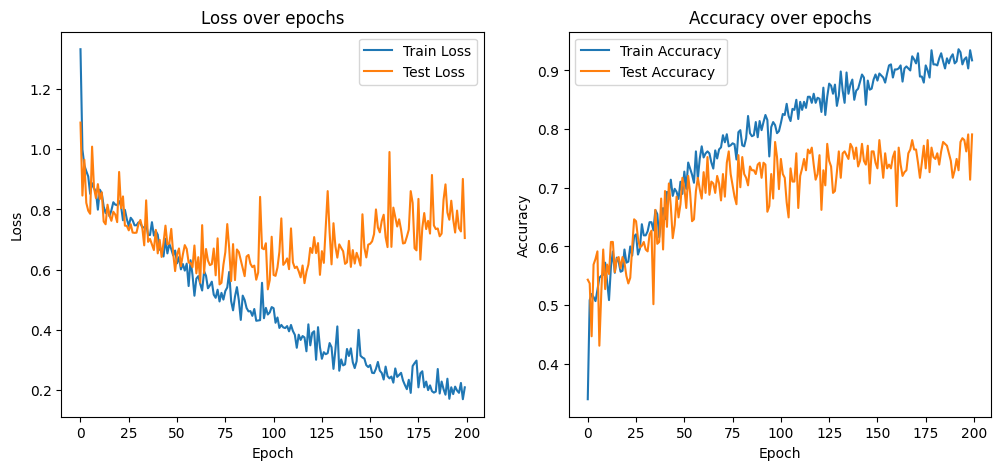

In [ ]:
model = CustomLeNet5()
opt = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("🤖 Training on", device)
history = train(model, opt, loss_fn, train_loader, test_loader, epochs=200, device='cpu')
#ถ้าเชื่อม GPU ได้ ใส่ device='cuda'
# Plotting loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['test_loss'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over epochs')

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['test_acc'], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over epochs')

plt.show()

In [ ]:
def k_fold_cross_validation(model_class, dataset, optimizer_class, optimizer_params, num_folds=3, num_epochs=4, batch_size=16, device=None):
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print("🤖 Training on", device)

    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(np.arange(len(dataset)))):
        print(f'\n🔀 Fold {fold+1}/{num_folds}')
        train_sampler = SubsetRandomSampler(train_idx)
        valid_sampler = SubsetRandomSampler(val_idx)
        train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, num_workers=16, pin_memory=True)
        valid_loader = DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler, num_workers=16, pin_memory=True)

        model = model_class().to(device)
        optimizer = optimizer_class(model.parameters(), **optimizer_params)
        loss_fn = nn.CrossEntropyLoss()

        for epoch in range(num_epochs):
            model.train()
            avg_train_loss = 0
            avg_test_loss = 0
            avg_train_acc = 0
            avg_test_acc = 0

            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                output = model(images)
                loss = loss_fn(output, labels)
                loss.backward()
                optimizer.step()
                avg_train_loss += loss.item()

                predicted = torch.argmax(nn.functional.softmax(output, dim=1), dim=1)
                train_correct_predictions = (predicted == labels).sum().item()
                avg_train_acc += train_correct_predictions / len(images)

            avg_train_loss /= len(train_loader)
            avg_train_acc /= len(train_loader)

            model.eval()
            with torch.no_grad():
                for images, labels in valid_loader:
                    images, labels = images.to(device), labels.to(device)
                    output = model(images)
                    loss = loss_fn(output, labels)
                    avg_test_loss += loss.item()

                    predicted = torch.argmax(nn.functional.softmax(output, dim=1), dim=1)
                    test_correct_predictions = (predicted == labels).sum().item()
                    avg_test_acc += test_correct_predictions / len(images)

            avg_test_loss /= len(valid_loader)
            avg_test_acc /= len(valid_loader)

            print(f"Summary for Fold {fold+1} - Epoch [{epoch+1}/{num_epochs}]:")
            print(f"\tTrain \tavg_loss: {avg_train_loss:.4f} \t| avg_acc: {avg_train_acc:.4f}")
            print(f"\tTest \tavg_loss: {avg_test_loss:.4f} \t| avg_acc: {avg_test_acc:.4f}")

        fold_results.append((avg_train_loss, avg_train_acc, avg_test_loss, avg_test_acc))

    avg_train_loss = sum([result[0] for result in fold_results]) / num_folds
    avg_train_acc = sum([result[1] for result in fold_results]) / num_folds
    avg_test_loss = sum([result[2] for result in fold_results]) / num_folds
    avg_test_acc = sum([result[3] for result in fold_results]) / num_folds

    print("\n🔎 K-Fold Cross Validation Results:")
    print(f"\tAverage Train Loss: {avg_train_loss:.4f}")
    print(f"\tAverage Train Accuracy: {avg_train_acc:.4f}")
    print(f"\tAverage Test Loss: {avg_test_loss:.4f}")
    print(f"\tAverage Test Accuracy: {avg_test_acc:.4f}")

    return fold_results, avg_train_loss, avg_train_acc, avg_test_loss, avg_test_acc

In [ ]:
optimizer_params = {'lr': 0.001}
fold_results, avg_train_loss, avg_train_acc, avg_test_loss, avg_test_acc = k_fold_cross_validation(
    CustomLeNet5,
    train_dataset,
    torch.optim.Adam,
    optimizer_params,
    num_folds=4,
    num_epochs=4,
    batch_size=16
)

🤖 Training on cpu

🔀 Fold 1/4


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Summary for Fold 1 - Epoch [1/4]:
	Train 	avg_loss: 1.3471 	| avg_acc: 0.3438
	Test 	avg_loss: 1.2878 	| avg_acc: 0.4437
Summary for Fold 1 - Epoch [2/4]:
	Train 	avg_loss: 1.1846 	| avg_acc: 0.4531
	Test 	avg_loss: 1.2185 	| avg_acc: 0.5125
Summary for Fold 1 - Epoch [3/4]:
	Train 	avg_loss: 0.9827 	| avg_acc: 0.4940
	Test 	avg_loss: 1.0554 	| avg_acc: 0.5750
Summary for Fold 1 - Epoch [4/4]:
	Train 	avg_loss: 0.9396 	| avg_acc: 0.4918
	Test 	avg_loss: 0.9667 	| avg_acc: 0.5437

🔀 Fold 2/4
Summary for Fold 2 - Epoch [1/4]:
	Train 	avg_loss: 1.3482 	| avg_acc: 0.3415
	Test 	avg_loss: 1.2988 	| avg_acc: 0.5375
Summary for Fold 2 - Epoch [2/4]:
	Train 	avg_loss: 1.2208 	| avg_acc: 0.4360
	Test 	avg_loss: 1.1934 	| avg_acc: 0.4938
Summary for Fold 2 - Epoch [3/4]:
	Train 	avg_loss: 1.0492 	| avg_acc: 0.4688
	Test 	avg_loss: 1.0660 	| avg_acc: 0.5125
Summary for Fold 2 - Epoch [4/4]:
	Train 	avg_loss: 0.9813 	| avg_acc: 0.4829
	Test 	avg_loss: 0.9653 	| avg_acc: 0.5813

🔀 Fold 3/4
Summary 

In [ ]:
class FeatureExtractor(nn.Module):
    def __init__(self, model, target_layers):
        super(FeatureExtractor, self).__init__()

        self.model = copy.deepcopy(model)
        self.target_layers = target_layers
        self.features = []

        for layer_name, layer in self.model.named_modules():
            if layer_name in target_layers:
                layer.register_forward_hook(self.save_feature(layer_name))

    def save_feature(self, layer_name):
        def hook(module, input, output):
            self.features.append(output)
        return hook

    def forward(self, x):
        self.features = []
        self.model(x)
        return self.features

In [ ]:
def visualize_feature_map(x,base_filename):
    out_dir = 'feature_map_result'
    os.makedirs(out_dir, exist_ok=True)
    x_channel_last = x[0].permute(1, 2, 0).cpu()

    num_channels = x_channel_last.size(2)

    num_rows = int(num_channels**0.5)
    num_cols = (num_channels // num_rows) + int(num_channels % num_rows > 0)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 8), subplot_kw={'xticks': [], 'yticks': []})
    for channel in range(num_channels):
        row = channel // num_cols
        col = channel % num_cols
        feat_m = x_channel_last[:, :, channel].detach().numpy()
        axes[row, col].imshow(feat_m, cmap='gray')
        axes[row, col].set_title(f'ch {channel + 1}\nrange: {feat_m.min(),feat_m.max()}',fontsize=7)


    base_filename = base_filename
    filename = f"{base_filename}.png"

    count = 1
    while os.path.exists(os.path.join(out_dir,filename)):
        filename = f"{base_filename}_{count}.png"
        count += 1
    fig.suptitle(filename.split('.')[0].split('/')[-1], fontsize=16)
    plt.tight_layout()
    plt.show()

In [ ]:
layer_names = []
for layer_name, layer in model.named_modules():
    if layer_name == '':
        continue
    layer_names.append(layer_name)
print(layer_names)

['conv1', 'relu1', 'pool1', 'conv2', 'relu2', 'pool2', 'flatten', 'fc1', 'relu3', 'fc2', 'relu4', 'fc3', 'relu5', 'fc4']


torch.Size([1, 3, 64, 64])
label: PadPakBung


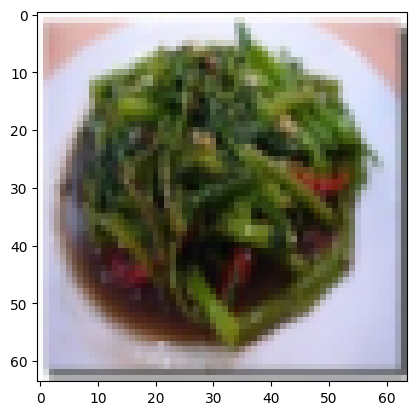

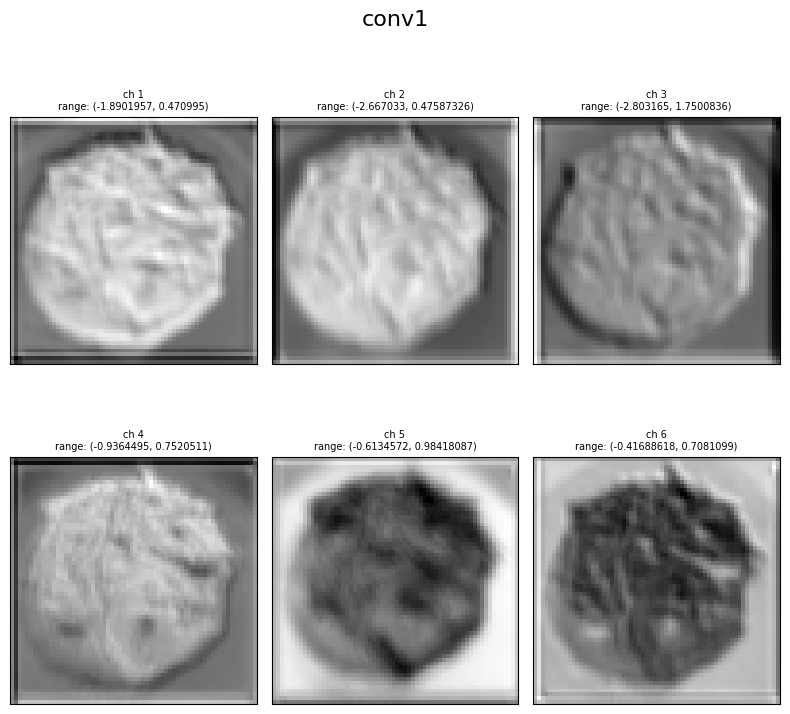

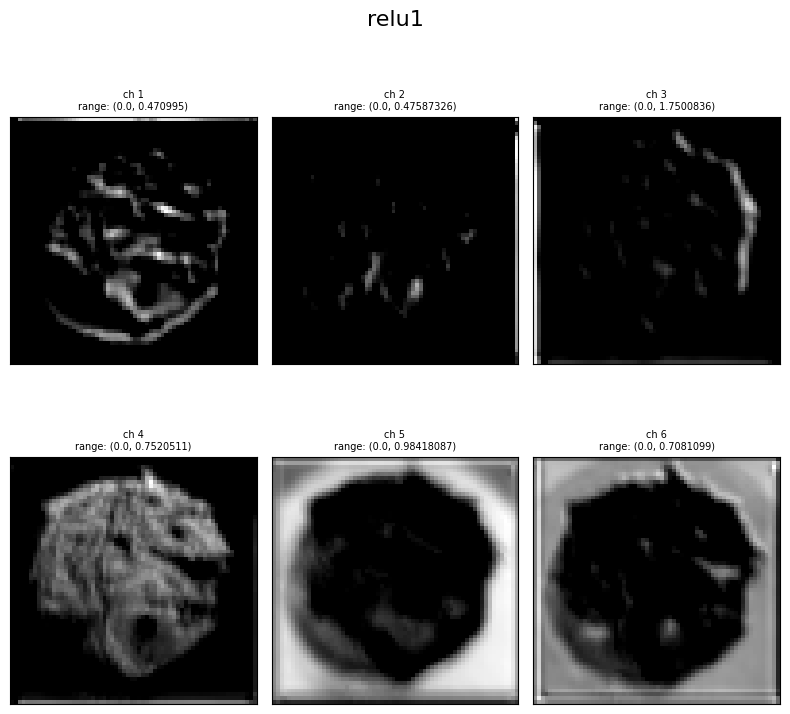

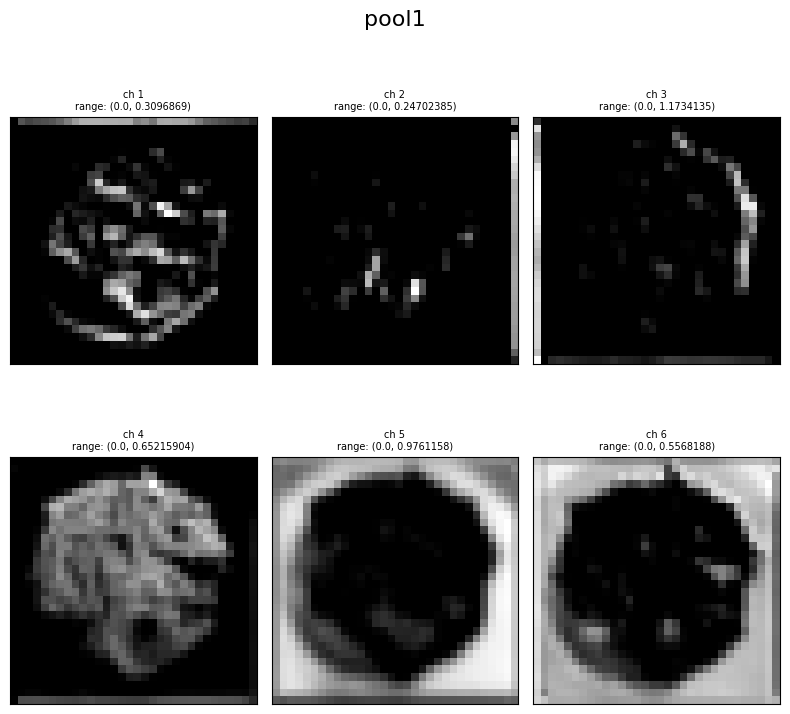

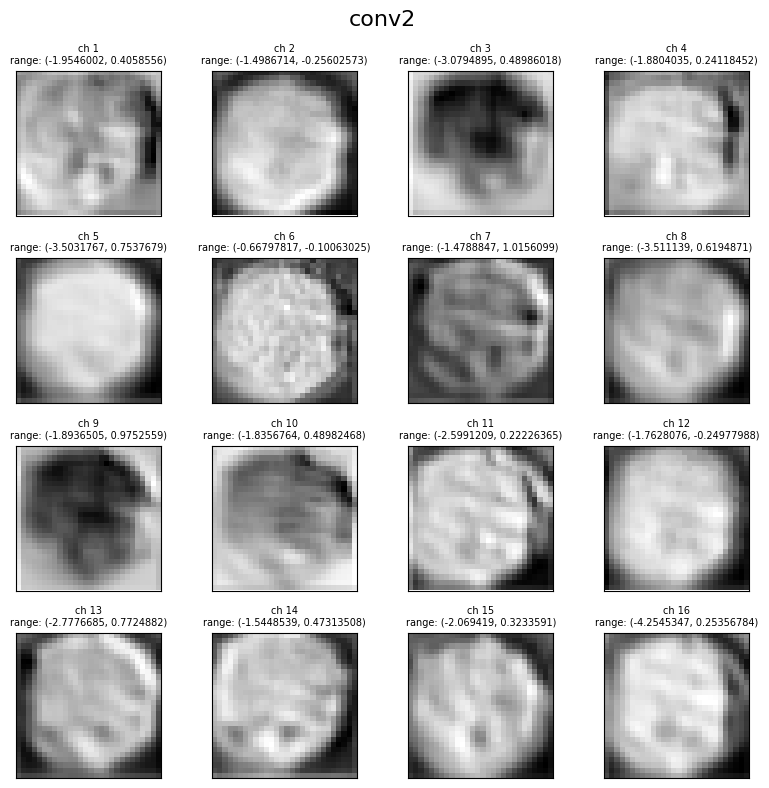

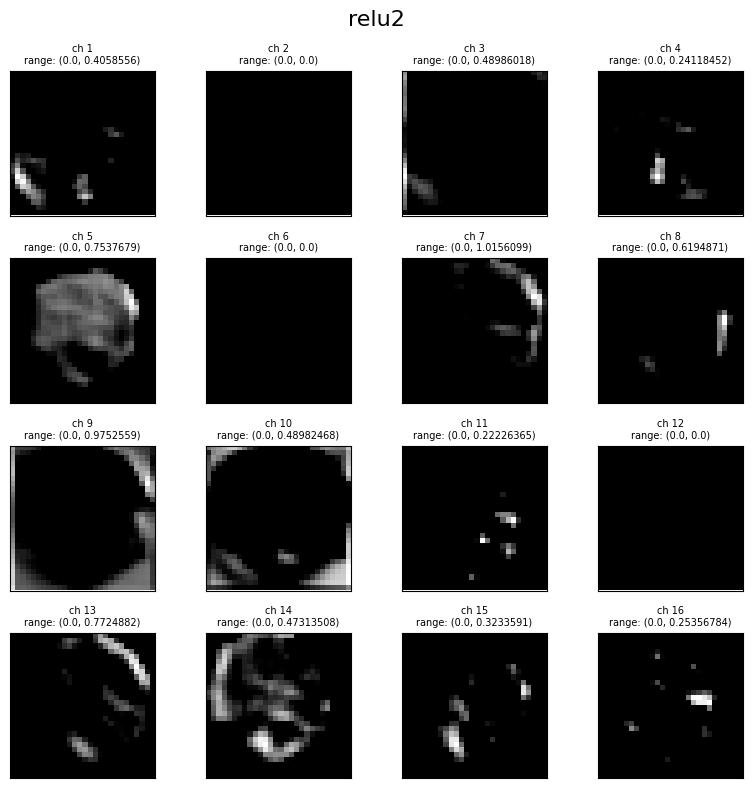

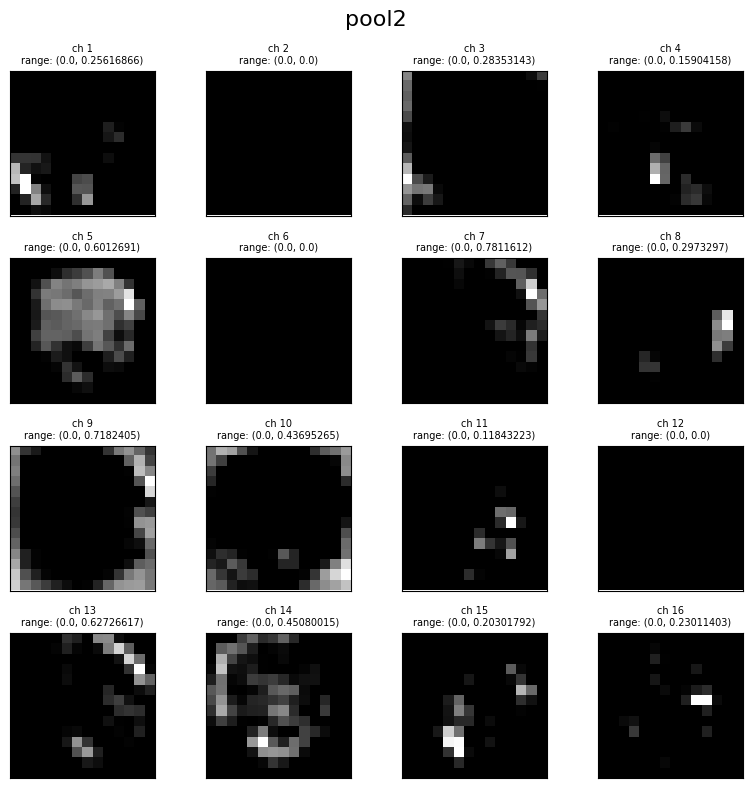

In [ ]:
layer_names = ['conv1', 'relu1', 'pool1', 'conv2', 'relu2', 'pool2']
class_names = ['BooPadPongali', 'FriedKale', 'MassamanGaii', 'PadPakBung']
batch, labels = next(iter(test_loader))

input_image = batch[0].unsqueeze(dim=0)
print(input_image.shape)
plt.imshow(input_image[0].permute(1, 2, 0))
print('label:',class_names[labels[0]])
feature_extractor = FeatureExtractor(model.eval(), layer_names)
feature_map = feature_extractor(input_image.to('cpu'))

for layer_name,feat in zip(layer_names,feature_map):
    visualize_feature_map(feat,layer_name)

In [ ]:
torch.save(model.state_dict(), 'wight_model.pth')
model.state_dict()

OrderedDict([('conv1.weight',
              tensor([[[[-8.3966e-02, -2.1172e-01, -7.9237e-02, -1.2284e-01,  4.5447e-02],
                        [-3.0828e-02, -2.3150e-01, -1.0754e-01, -7.1478e-02,  9.9758e-03],
                        [-5.7429e-02, -2.3977e-01, -5.8788e-02, -4.1138e-02, -1.3261e-01],
                        [-2.5337e-02, -3.7773e-02, -2.1220e-01, -1.5949e-01,  5.9298e-02],
                        [ 8.8498e-02, -4.4532e-02, -5.3651e-02,  3.9533e-02,  6.7901e-02]],
              
                       [[ 1.0082e-02, -4.4428e-02,  7.1036e-02, -4.4685e-02, -3.6628e-02],
                        [-4.6292e-02, -8.2930e-02,  2.6377e-02, -6.9001e-02, -5.4554e-02],
                        [ 9.9771e-02,  6.8412e-02, -7.4317e-02, -3.6807e-02, -6.3359e-02],
                        [ 1.1376e-01,  5.4872e-02,  1.0489e-01, -3.8690e-02,  1.2082e-02],
                        [ 2.1989e-01,  2.0037e-01,  2.1148e-01,  1.2334e-01,  1.7830e-01]],
              
                       [[ 3.

In [ ]:
def load_model(model,model_path):
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

def plot_confusion_matrix(ax, cm, title, labels):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

def summary_confusion_matrix(model, class_names):
    model = model.cpu()
    true_labels = []
    predicted_labels = []
    for images, labels in test_loader:
        images = images.cpu()
        labels = torch.tensor(labels)

        with torch.no_grad():
            output = model(images)
            predicted = output.argmax(dim=1).cpu().numpy()

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted)

    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)
    report = classification_report(true_labels, predicted_labels, target_names=class_names)
    print(report)
    cm = confusion_matrix(true_labels, predicted_labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

<ipython-input-40-881c84dcf0f5>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


               precision    recall  f1-score   support

BooPadPongali       0.79      0.81      0.80       102
    FriedKale       0.80      0.83      0.81        98
 MassamanGaii       0.84      0.77      0.80        74
   PadPakBung       0.68      0.68      0.68        37

     accuracy                           0.79       311
    macro avg       0.78      0.77      0.77       311
 weighted avg       0.79      0.79      0.79       311



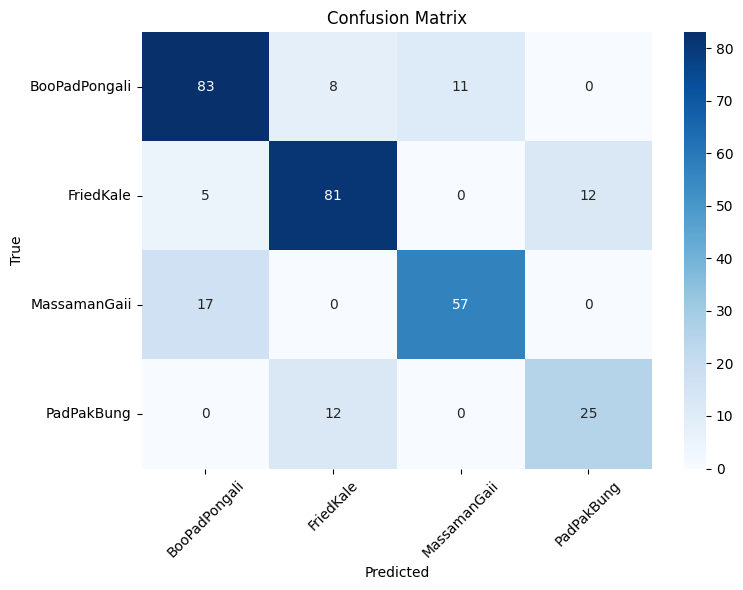

In [ ]:
class_names = ['BooPadPongali', 'FriedKale', 'MassamanGaii', 'PadPakBung']
summary_confusion_matrix(model, class_names)